# Dynamic Modelling Course - TEP4290: Warm-up 15
## Curve fitting and regression examples with Python
This warm-up will introduce some ways to fit curves to your data in Python - something that you will need to do for your project.

The field of regression is wast and their is no ultimative guide, so we don't want to single out any tutorials here, but don't let that stop you from using other resources to help you with this topic!


In this notebook you will find some basic explanation and first tools for regression in python, which you will then use to do some small tasks yourself.


Good luck!

In [2]:
import numpy as np
import pandas as pd
import copy

import matplotlib.pyplot as plt
from datetime import datetime

from scipy.optimize import curve_fit
import natural_cubic_spline_stack_overflow as ncs # taken from stack overflow

from sklearn.metrics import r2_score

We also set up functions for a logistic curve - we will need this for curve fitting, and a noise function, which we use for generating data.

In [3]:
#define logistic function and noise function
def logistic(x:np.ndarray,ti:float,tau:float,C0:float,C1:float) -> np.ndarray:
    """
    General logistic function.
    Arguments:
    - x: np.ndarray of observation points (time)
    - ti: inflection time
    - tau: transition time coefficient
    - C0: start value
    - C1: end value

    Returns:
    - np.ndarray with len(x) number of points
    """
    return (C1 - C0)/(1 + np.exp(-(x - ti) / tau)) + C0  


def noise(start: int, stop: int, lo_time_deltas: list, lo_deviations: list) -> np.ndarray:
    '''
    Generates noise for timeseries for a set of time deltas and 
    deviations.This works by setting random deviations at certain 
    intervals and interpolating the points in between.The noise can then
    simply be added to the smooth timeseries curve to generate the final
    timeseries.
    
    Arguments:
    - start: beginning of the timeseries
    - stop: end of the timeseries
    - lo_time_deltas: list of time deltas which set the points at which 
                      noise trends are set
    - lo_deviations: the respective standard deviation from which the 
                     deviation for each point is drawn.

    Returns:
    - np.ndarray with stop-start+1 values of noise, averaging around 0
    '''
    no_time = stop-start +1 #number of discrete time instances
    final_points = np.zeros(no_time)

    for (time_delta, deviation) in zip(lo_time_deltas, lo_deviations):
        no_points = int((no_time-1)/time_delta)+2 #1 more than necessary to extend series
        end_time = start + (no_points-1)*time_delta
        macro_points = np.random.normal(0, deviation, no_points) 
        macro_point_x = np.linspace(start, end_time,no_points)
        macro_point_x = np.delete(macro_point_x, -1) #delete the extra point here


        extended_macro_points = [macro_points[0]]
        for index, macro_point in enumerate(macro_points[1:]):
            connection = np.linspace(macro_points[index], macro_point, time_delta+1, endpoint=True)
            extended_macro_points.extend(connection[1:])
        extended_macro_points = np.array(extended_macro_points[0:no_time])
        macro_points = np.delete(macro_points, -1)

        final_points = np.add(final_points, extended_macro_points)

    return final_points

# Why we do regression/fitting: 
Fitting curves to data points can help us understanding the true function (development) of some value over time, but also serve as a simple way to bridge gaps in the raw data and smoothen out noise. 

We will demonstrate this with a given function, which represents a true relationship between time and values. 

The plots below show the full series of (true) values, and some alterations of this, where the time series is cut short, lacks some values, is represented but multiple noisy values or by a single timeseries to which we added noise.

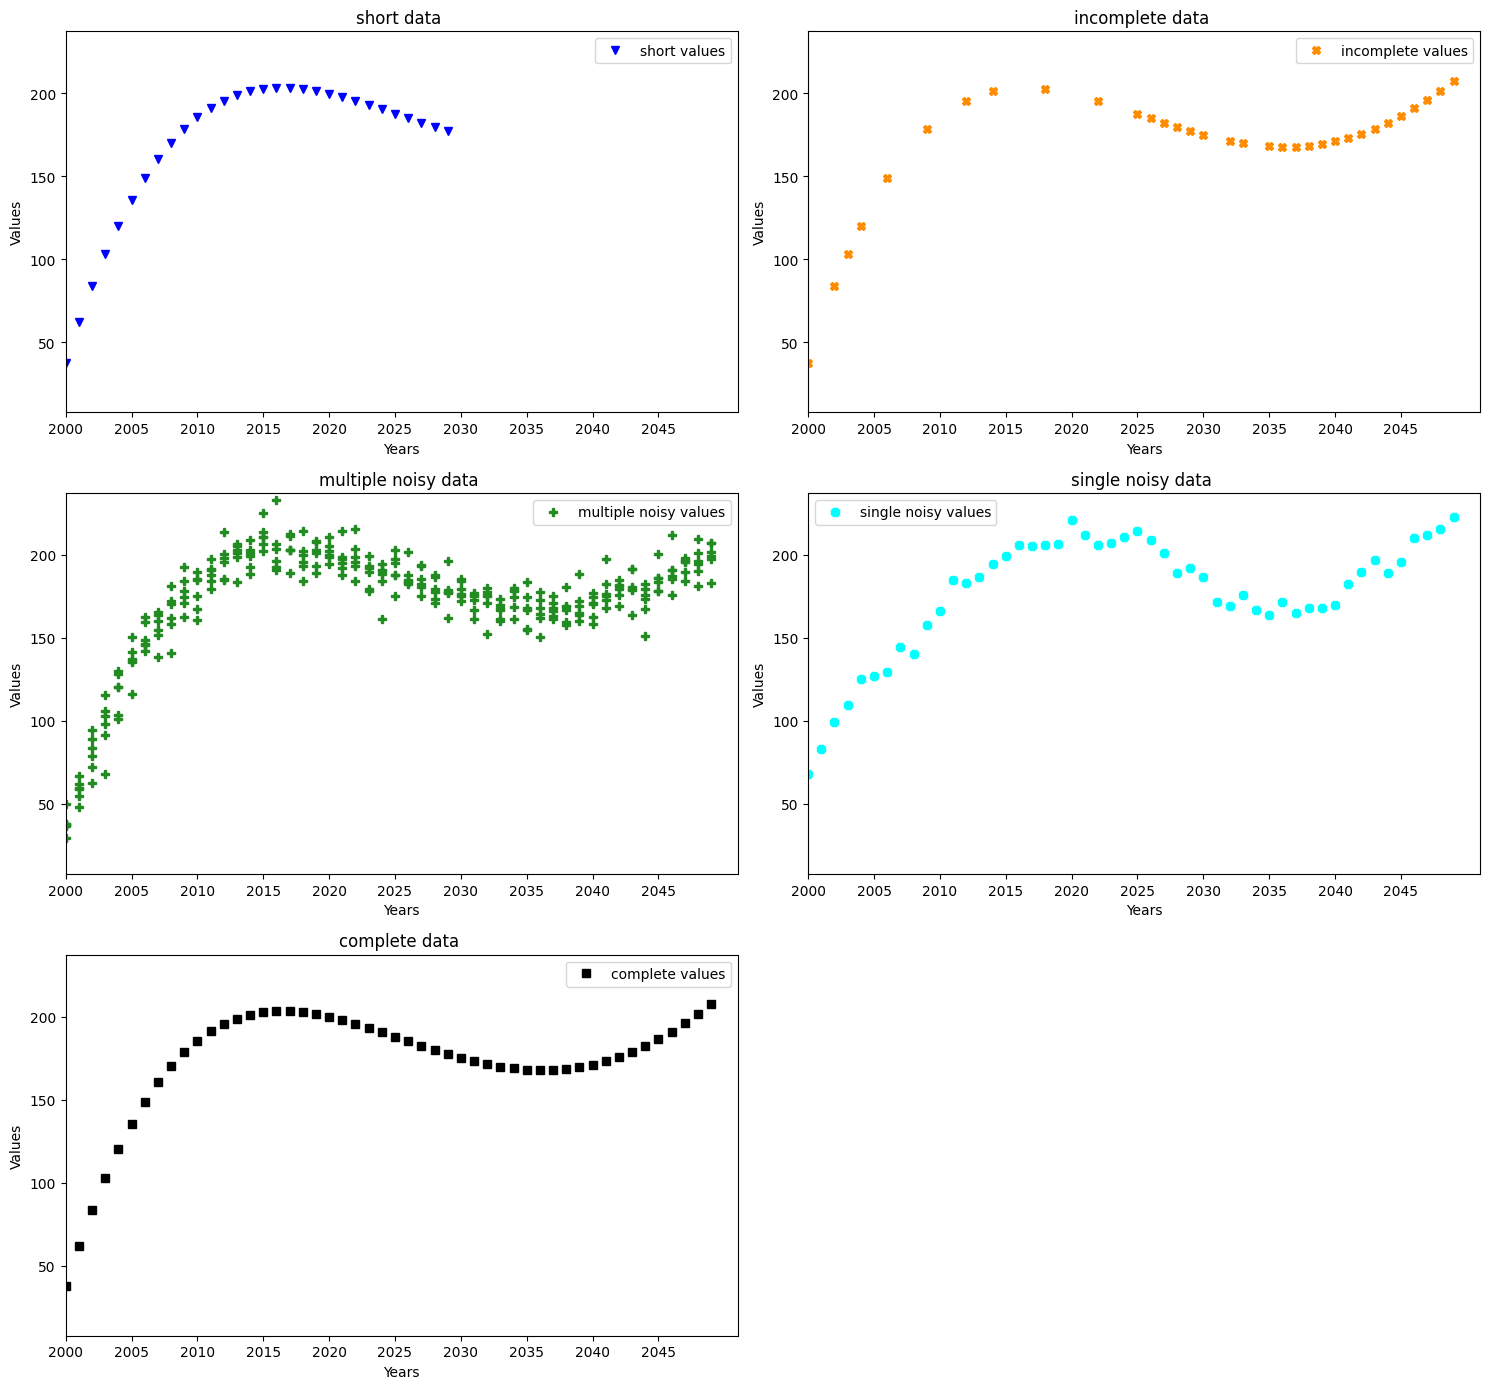

In [4]:
#we start by setting some true values for a timeseries with a (some) function:
weight = 0
def true_function(x):
    '''Simple polynomial that looks nice for our values'''
    x = x-2000
    y =  -(x-25)**4/(7*10**3)   + ((x-22)**3)/100 - (x**2)/10  + x*2+ 200 + weight*np.sin(x)
    #y =  (x/3)** 2 + 60 + weight*np.sin(x)
    return y
start = 2000
duration = 50


#the basic values:
oj_years = np.linspace(start, start+duration-1, duration)
oj_values = true_function(oj_years)



np.random.seed(seed = 2)
#incomplete values:
#_______________________________________________________________________
# we set indices for what should dissapear - points between 0 and 80% of 
# the range, 35% of them are removed
limit = int(duration*0.8)
removed_share = int(duration*0.35)
removed_indices = [int(i) for i in np.sort(np.random.uniform(0,limit, removed_share))]
incomplete_years = copy.deepcopy(oj_years)
incomplete_values = copy.deepcopy(oj_values)

remover_counter = 0
for index in removed_indices:
    incomplete_years = np.delete(incomplete_years, index-remover_counter)
    incomplete_values = np.delete(incomplete_values, index-remover_counter)
    remover_counter += 1

#multi noise values:
#_______________________________________________________________________

no_multi_noise_points = 5
multi_noise_level = 10
multi_noisy_years = copy.deepcopy(oj_years)
multi_noisy_values = copy.deepcopy(oj_values)
for index, (year, value) in enumerate(zip(oj_years, oj_values)):
    for _ in range(no_multi_noise_points):
        multi_noisy_years = np.insert(multi_noisy_years,index*(no_multi_noise_points+1), year)
        new_value = np.random.normal(0, multi_noise_level,1) + value
        multi_noisy_values = np.insert(multi_noisy_values, index*(no_multi_noise_points+1),new_value)

#noisy values:
#____________________________________________________________________________
single_noise_years = copy.deepcopy(oj_years)
single_noise_distance = [1,8]
single_noise_std = [5, 15]
single_noise = noise(1,duration, single_noise_distance, single_noise_std)
single_noise_values = oj_values + single_noise


#short data:
#____________________________________________________________________________
short_years = oj_years[0:int(duration*0.6)]
short_values = oj_values[0:int(duration*0.6)]




labels = ['short', 'incomplete', 'multiple noisy', 'single noisy', 'complete' ]
lo_years = [short_years, incomplete_years, multi_noisy_years, single_noise_years, oj_years]
lo_values = [short_values, incomplete_values, multi_noisy_values, single_noise_values, oj_values]
lo_symbols = ['v', 'X', 'P','8', 's']
lo_colors = ['blue', 'darkorange', 'forestgreen', 'cyan','black']

#preparing the figure:
rows = 3
cols = 2
axes=[]
#the expected y limits for the plot:
limits = []
for base in [min(oj_values), max(oj_values)]:
    for sign in [-1,1]:
        limits.append(base+ sign*(weight+ 2*max([multi_noise_level, max(single_noise_std)])))

fig=plt.figure(figsize = (15,14))
for index, (label, years, values, symbol, colour) in enumerate(zip(labels, lo_years, lo_values, 
                                                                   lo_symbols, lo_colors)):
    axes.append( fig.add_subplot(rows, cols, index+1) )
    subplot_title=(f"{label} data ")
    axes[-1].set_title(subplot_title) 
    plt.plot(years, values, symbol, color = colour, label = f'{label} values')
    plt.legend(loc = 'best')
    plt.xticks(ticks = np.rint(oj_years[::int(duration/10)]))
    plt.xlabel('Years')
    plt.ylabel('Values')
    plt.xlim(start,start+duration+1)
    plt.ylim(min(limits), max(limits))
fig.tight_layout()
plt.show()


For a human it is rather easy to close the gaps, expand the values in a reasonable way or to find a probable mean for each point in time. 

To make a computer do the same is a very different story - we need to give some indication what relationship we expect, and if we pick wrong here, the fit will be bad.

The figure below shows the behaviour of several generic methods on the same data set and alterations of it as we saw above.

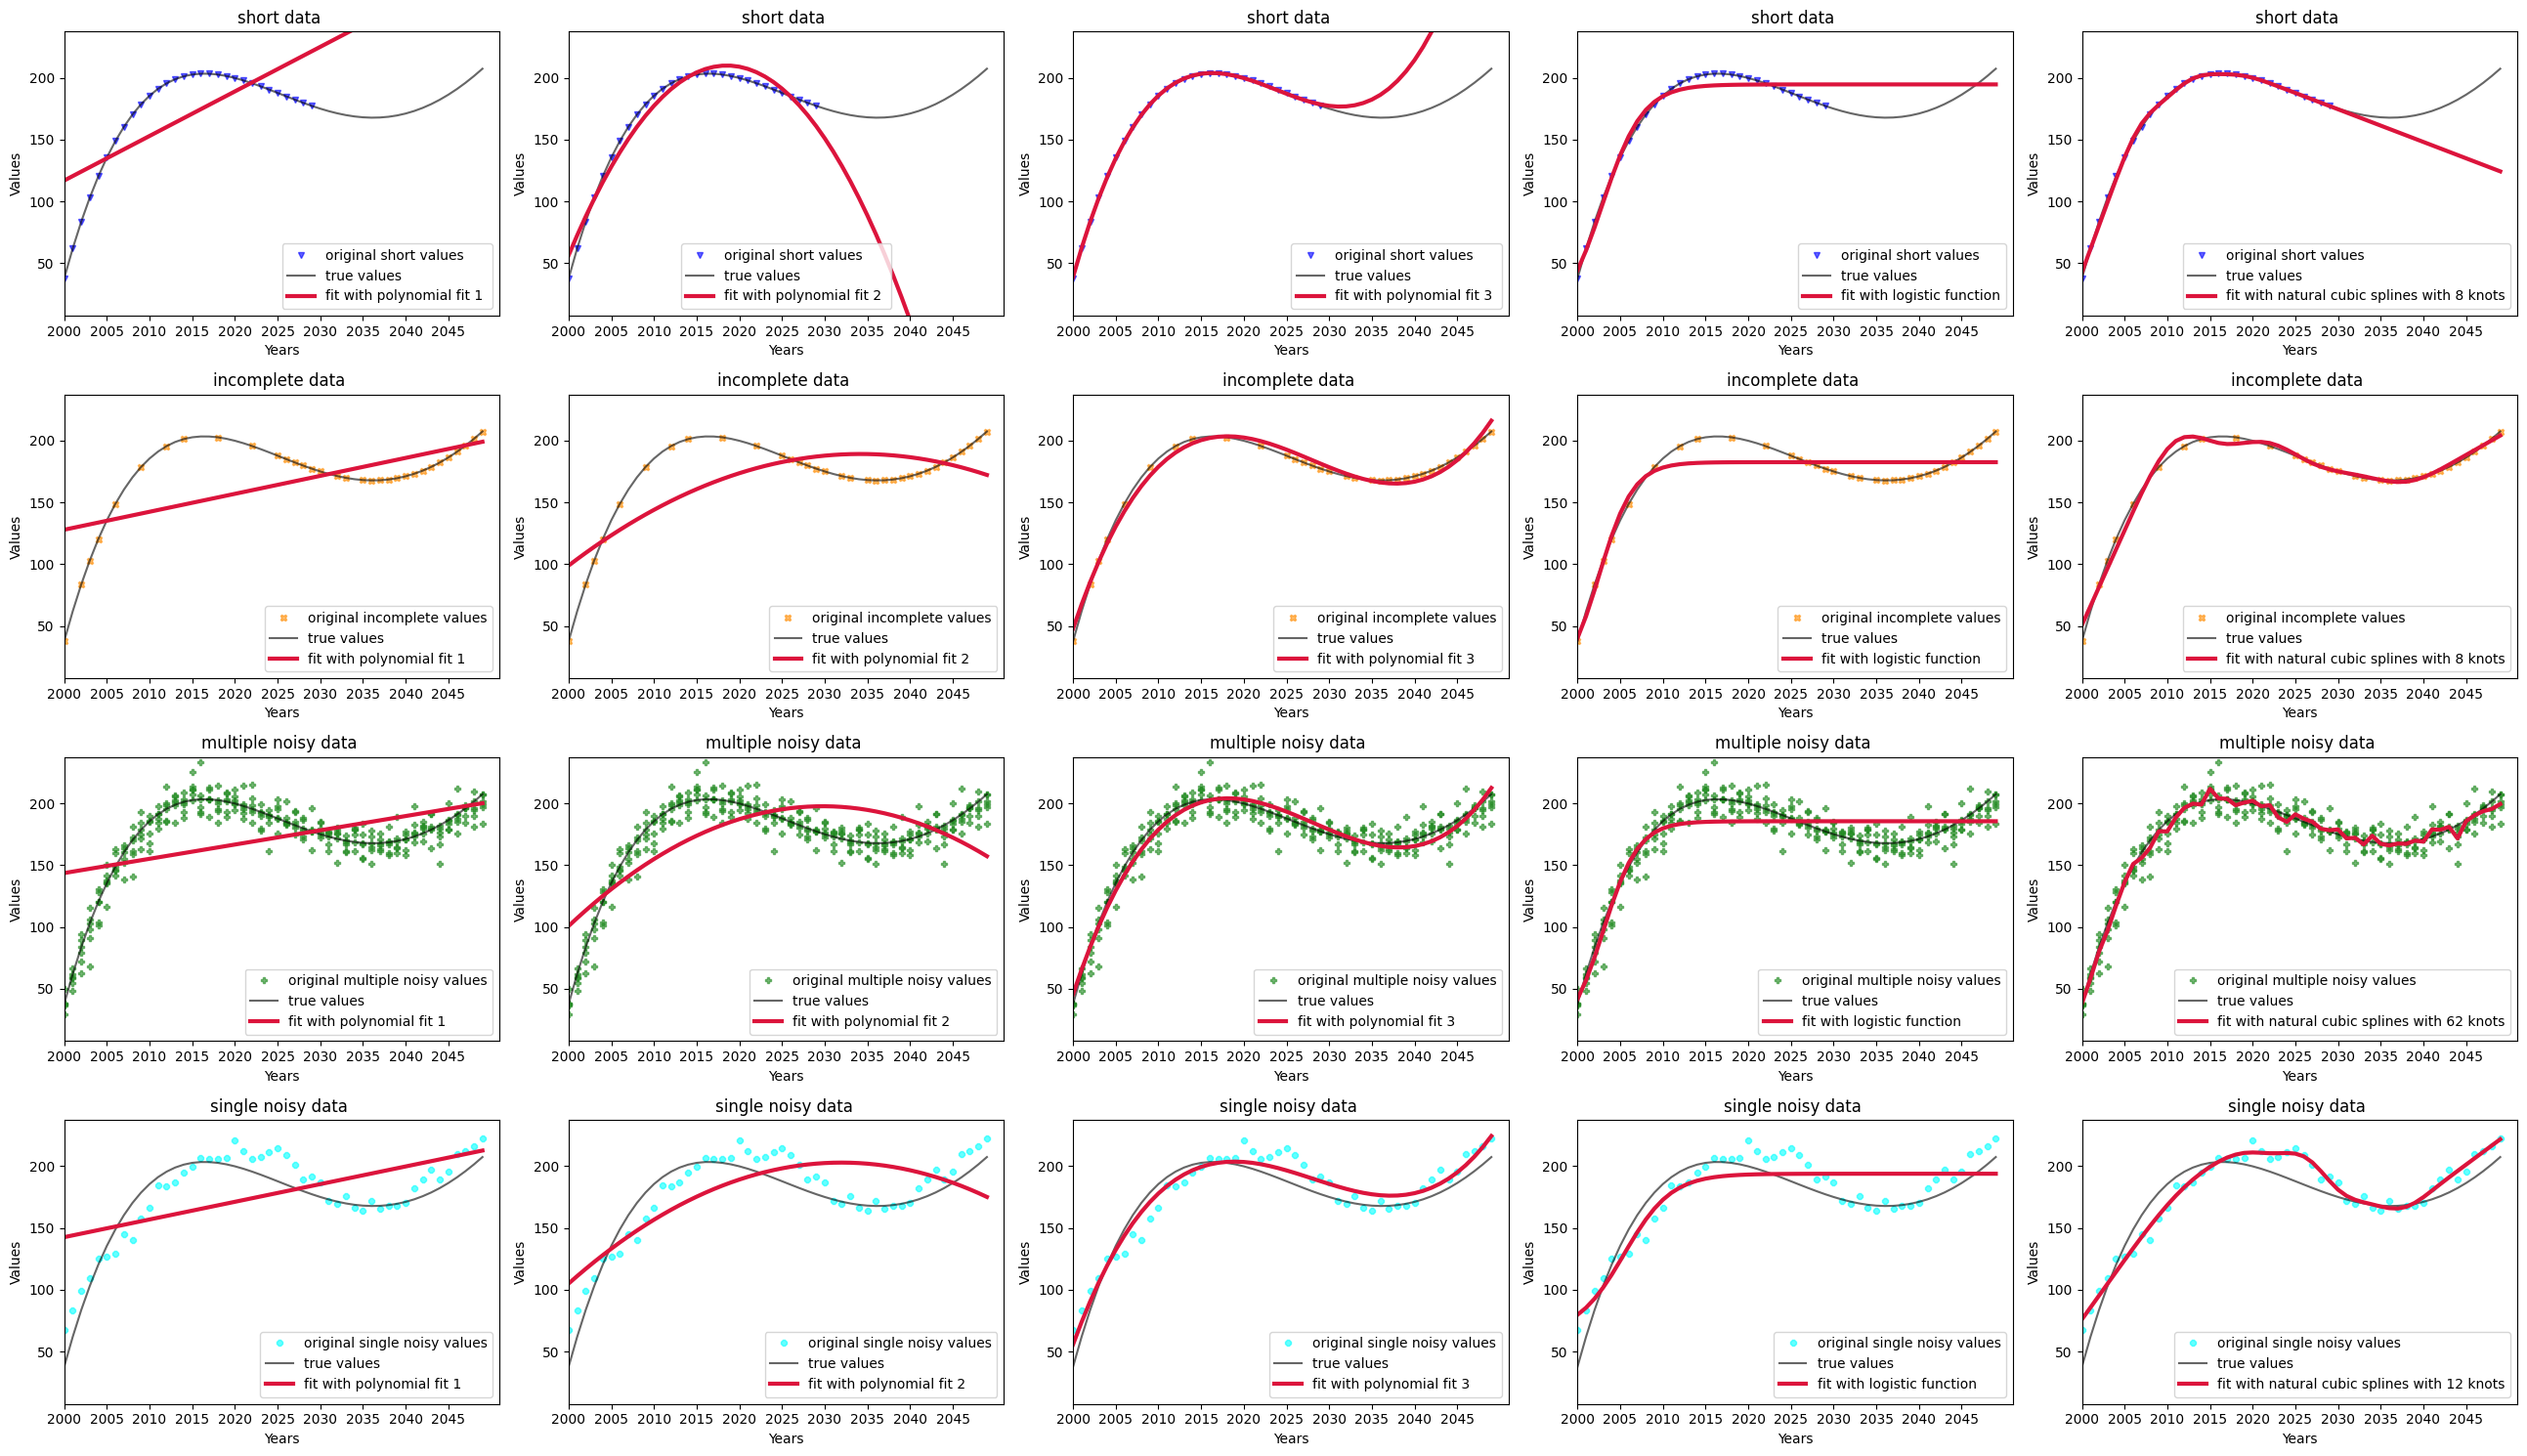

In [5]:
#list of fits we will perform:
lo_fits = [1,2,3, 'logistic','ncs']

#preparing the figure:
rows = len(labels)-1 #no need to include the full values
cols = len(lo_fits) 
axes=[]
fig=plt.figure(figsize = (26,15))
#for each dataset and entourage
for index, (label, years, values, symbol, colour, _) in enumerate(zip(labels, lo_years, lo_values, lo_symbols, lo_colors, [_,_,_,_])): 
    counter = 1
    #for each possible fit
    for fit in lo_fits:
        #fit the values:
        if isinstance(fit, int):
            polynomial = np.poly1d(np.polyfit(years, values, fit))
            fitted_values = polynomial(oj_years)
            fit_label = f'polynomial fit {fit} '
        elif fit == 'logistic':
            popt, pcov = curve_fit(logistic, years, values,bounds = ([min(years), 0, 0, 0], [max(years), 10**5, 10**4, 10**5]))
            fitted_values = logistic(oj_years, *popt)
            fit_label = 'logistic function'
        elif fit == 'ncs':
            no_knots = int(len(values)/5) + 2
            ncs_model = ncs.get_natural_cubic_spline_model(years, values, minval=min(years), maxval=max(years), n_knots = no_knots)
            fitted_values = ncs_model.predict(oj_years)
            fit_label = f'natural cubic splines with {no_knots} knots'
        #then plot them in a subplot
        axes.append( fig.add_subplot(rows, cols, index*len(lo_fits)+counter) )
        counter +=1
        subplot_title=(f"{label} data ")
        axes[-1].set_title(subplot_title) 
        
        plt.plot(years, values, symbol, color = colour, alpha = 0.6, markersize = 5, label = f'original {label} values')
        plt.plot(oj_years, oj_values, color = 'black',alpha = 0.6, label = 'true values')
        plt.plot(oj_years, fitted_values, color = 'crimson', lw = 3,  label = f'fit with {fit_label}' )
        plt.legend(loc = 'best')
        plt.xticks(ticks = np.rint(oj_years[::int(duration/10)]))
        plt.xlabel('Years')
        plt.ylabel('Values')
        plt.xlim(start,start+duration+1)
        plt.ylim(min(limits), max(limits))

fig.tight_layout()
plt.show()


## Regression - the idea

The core idea of regression is to uncover the true relationship between a dependent (outcome or response) variable and an independent variable (predictor, covariate, input).
<br>
This can be formalized as the following:

\begin{equation}
    \textbf{Y} = \textbf{F(X)}
\end{equation}

Where $\textbf{Y}$ is a vector of outputs (for example population) and $\textbf{X}$ a matrix of input or predictor values (for example time). 
<br>
Since there will be some irreducible random error in almost all real applications, we have to settle for the following:

\begin{equation}
    \textbf{Y} = \textbf{F(X)} +\epsilon
\end{equation}

Where $\epsilon$ is an error term which can represent any number of issues with measuring the values of the outcome variable.

### Linear regression

$\textit{If}$ we assume the true relationship between inputs(predictor variabes) and outputs to be a linear one, we get 

\begin{equation}
    \textbf{Y} = \beta \textbf{X}+ \epsilon
\end{equation}

Where $\beta$ represents the weights of the input variables, and for a single input becomes a scalar.
<br>
That means that linear regression boils down to finding the $\beta$ that best fits the available data - how this is done is not really important for us. However, once we find $\beta$, we can predict the outcome variable for any value of the input variable.



### Example: linear regression on part of the original data set
We can demonstrate this on the first 35% of the data set: 
- we cut the data short (black points)
- create a linear model based on the cut values (print and dotted line)
- use this to predict future values (red stars)

 the linear model our fit created is  
9.935 x - 1.98e+04.


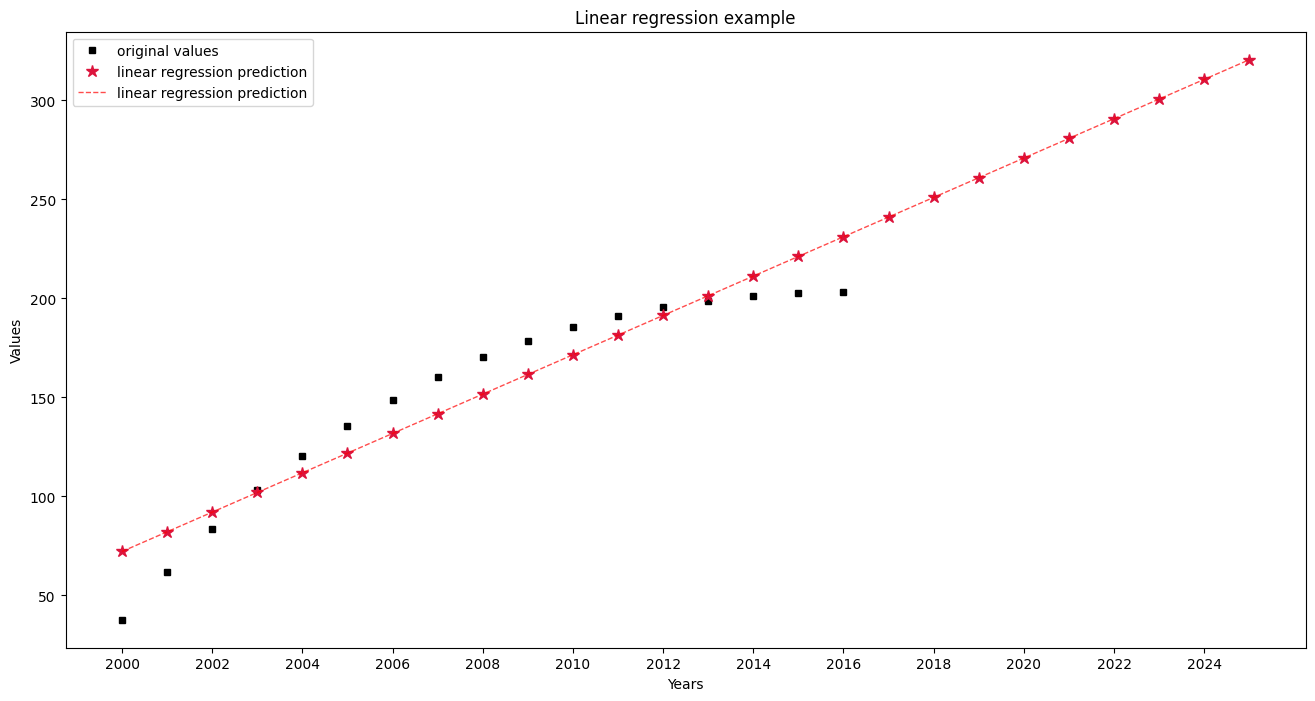

In [6]:
#create the short data set for the regression
perc = 35
limit = int(len(oj_years)*perc/100) #limit to the first perc % of the data
limit_pred = int(len(oj_years)* (perc/100)*1.5) #limit the prediction to 1.5* perc % of the data
reg_years = oj_years[0:limit]
reg_values = oj_values[0:limit]

reg_predictor_years = oj_years[0:limit_pred]

#perform regression:
#find beta
linear_model = np.poly1d(np.polyfit(reg_years, reg_values, 1))
print(f' the linear model our fit created is {linear_model}.')
#apply to extended values
lin_reg_fitted_values = linear_model(reg_predictor_years)


fig=plt.figure(figsize = (16,8))
plt.plot(reg_years, reg_values, 's', color = 'black', markersize = 5, label = f'original values')
plt.plot(reg_predictor_years, lin_reg_fitted_values, '*', ms = 9, color = 'crimson', label = 'linear regression prediction')
plt.plot(reg_predictor_years, lin_reg_fitted_values, '--', lw = 1 ,alpha = 0.7,  color = 'red', label = 'linear regression prediction')
#plt.plot(oj_years, fitted_values, color = 'crimson', lw = 3,  label = f'fit with {fit_label}' )
plt.legend(loc = 'best')
plt.xticks(ticks = np.rint(oj_years[:limit_pred:int(len(reg_predictor_years)/10)]))
plt.xlabel('Years')
plt.ylabel('Values')
plt.title(f'Linear regression example')
plt.show()

## Types of regression (for this class)
Regression analysis is an extremely complex topic, that is a valid field of study on its own.
<br>
Because all we want to do is to do some basic predictions on typically very sparse data sets, we will demonstrate three basic techniques to you, which should cover your needs.
<br>
However, you are welcome to expand your reportoire and use other techniques!

Relevant methods for this class:
- polynomial regression
- logistic regression
- natural cubic splines

The difference between these methods is what we assume to be the true relationship between output and input variables. For polynomial regression this is a polynomial of specified degree, logistic regression assumes a logistic function and natural cubic splines assumes that for different parts of the input variable space (e.g., different times) different polynomials of degree are the best approximation - with smoothed overlaps and linear functions at the extrem ends.


### Common ground: training data
All regression methods require something called training data. These are data points that the model uses to find its values, so the quality of the training data determines the quality of the predictions!

### Polynomial regression
With the linear regression we already saw one example for polynomial regression. Generally speaking, polynomials of degrees higher than four are extremely unlikely to be a good choice, so we basically can choose between linear, quadratic and cubic (maybe degree 4) polynomials

\begin{equation}
    \textbf{Y} = b\cdot + \textbf{X} + a
\end{equation}
or

\begin{equation}
    \textbf{Y} = c \cdot \textbf{X}^2 + b\cdot  \textbf{X} + a
\end{equation}
or 

\begin{equation}
    \textbf{Y} = d\cdot\textbf{X}^3 + c \cdot \textbf{X}^2 + b\cdot  \textbf{X} + a
\end{equation}

so we need to find [a,b], [a,b,c] or [a,b,c,d].
In Python this is can all be done automatically with numpy's function polyfit; numpy's poly1d function can then help to wrap the result such that we can treat the result like any polynomial function.
<br>
(Full documentation: https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)

#### how to use np.polyfit and np.poly1d:


 the polynomial our fit created is: 
         2
-0.7764 x + 3128 x - 3.15e+06.


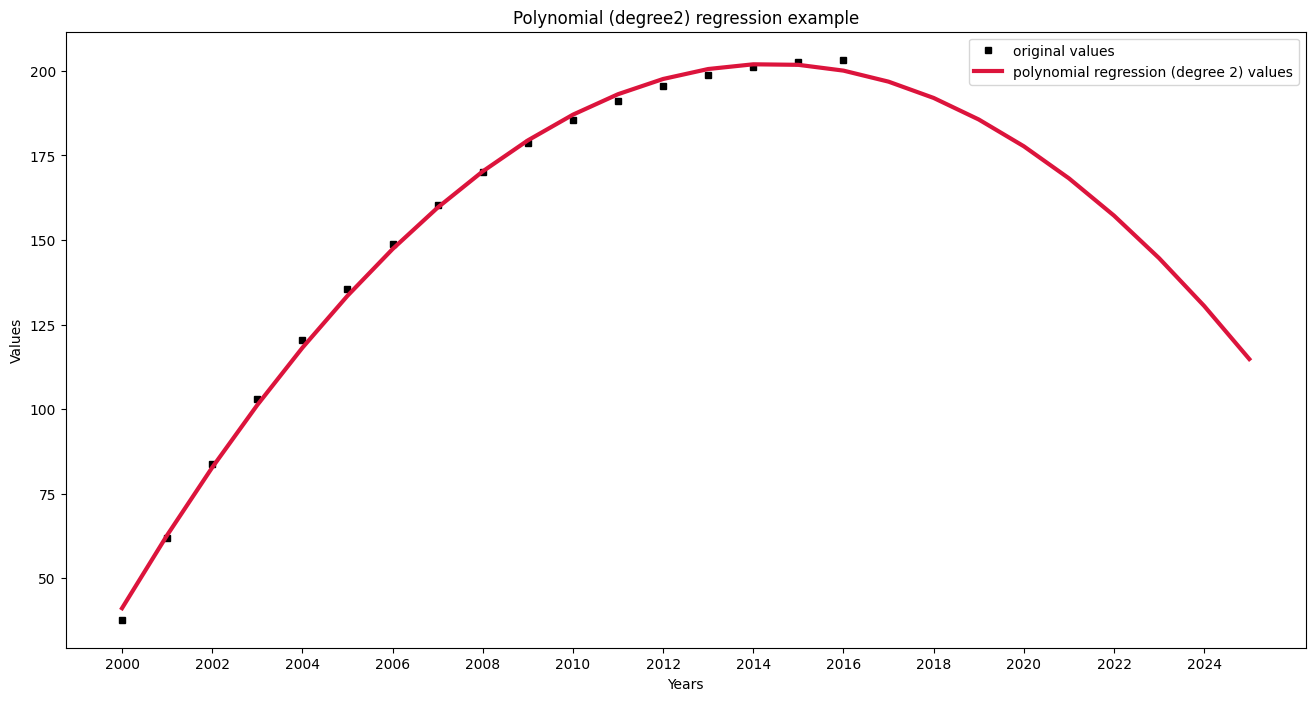

In [18]:
inputs = reg_years
outputs = reg_values
pred_inputs = reg_predictor_years

#perform regression:
#set degreee:
degree = 2
#find polynomial
polynomial = np.poly1d(np.polyfit(reg_years, reg_values, degree))
print(f' the polynomial our fit created is: \n{polynomial}.')
#apply to extended values
pred_outputs = polynomial(reg_predictor_years)


fig=plt.figure(figsize = (16,8))
plt.plot(reg_years, reg_values, 's', color = 'black', markersize = 5, label = f'original values')
plt.plot(pred_inputs, pred_outputs, color = 'crimson', lw = 3, label = f'polynomial regression (degree {degree}) values')
plt.legend(loc = 'best')
plt.xticks(ticks = np.rint(oj_years[:limit_pred:int(len(reg_predictor_years)/10)]))
plt.title(f'Polynomial (degree{degree}) regression example')
plt.xlabel('Years')
plt.ylabel('Values')
plt.show()



### Logistic regression
For a logistic regression we assume that the outcome variable has a one time increase dependent on the input variable and remains at aconstant level prior and past that.
We already defined the logistic function in our imports:

\begin{equation}
    \textbf{Y} = \frac{C_1 - C_0}{1+ e^{\frac{-(\textbf{X}-t_i)}{\tau}} } + C_0
\end{equation}
Where:
- $\textbf{X}$ reprents the input variable
- $t_i$:  is the inflection time
- $\tau$ is the transition time coefficient
- $C_0$ is the start value
- $C_1$ is the end value

All parameters (except $\textbf{X}$) need to be found during the fitting. We can use scipy's curve_fit function - it takes a function, its inputs and outputs as three separate arguments and returns the optimal parameter values (popt) an their covariance (pcov).
<br>
We can use the function the following way:
popt, pcov = curve_fit(function, inputs, outputs)
pred_outputs = function(inputs. *popt)
<br>
**Note** that you may help the regression by suppplying bounds as a tuple of vectors (lower and upper limits).
<br>
(for the full documentation see here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

we can use the same values as above:

#### How to use scipy's curve_fit with the logistic function

The optimal choice of parameters for the logistic function, given the sample data, is [2.00318858e+03 2.71350183e+00 1.02967538e-16 2.03019304e+02] (ti, tau, C0, C1).


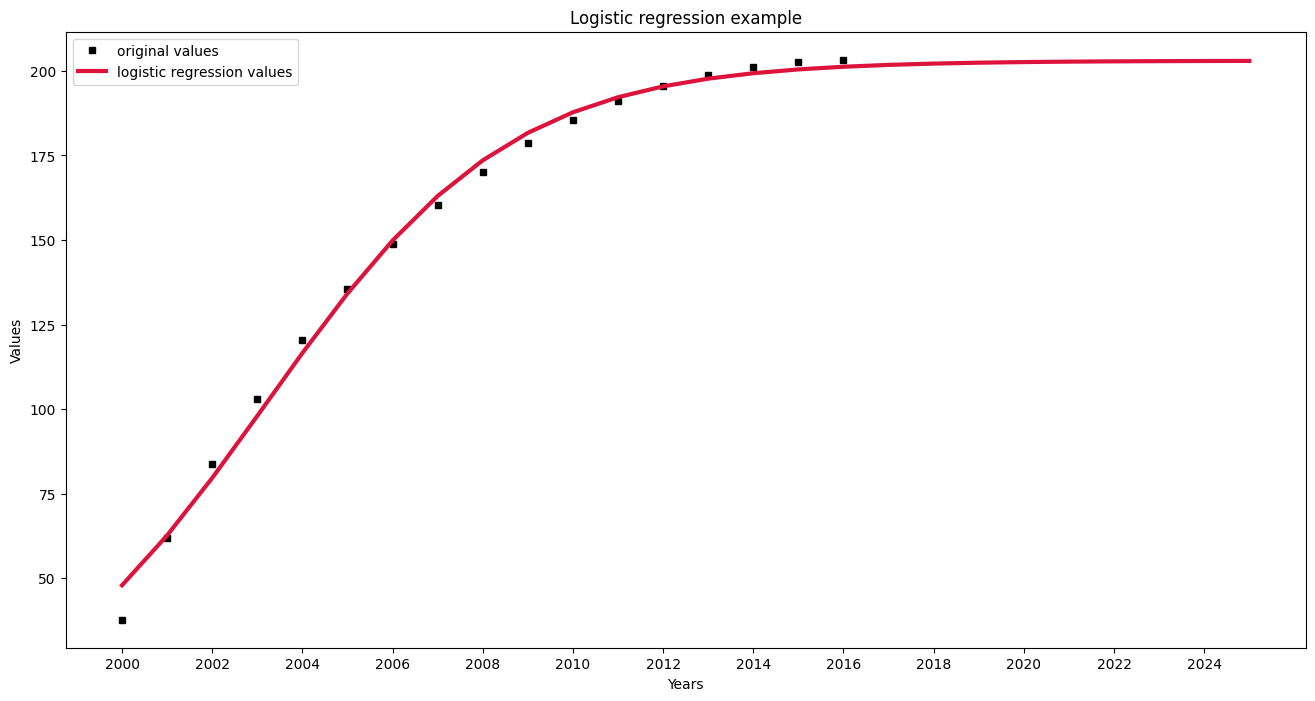

In [19]:
inputs = reg_years
outputs = reg_values
pred_inputs = reg_predictor_years

# it might be necessary to adjust the bounds argument, 
# determining the extreme acceptable value for the parameters of the logistic function.
# Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
popt, pcov = curve_fit(logistic, inputs, outputs, bounds = ([min(inputs), 0, 0, 0], [max(inputs), 10**5, 10**4, 10**5]))
pred_outputs = logistic(pred_inputs, *popt)

print(f'The optimal choice of parameters for the logistic function, given the sample data, is {popt} (ti, tau, C0, C1).')

fig=plt.figure(figsize = (16,8))
plt.plot(reg_years, reg_values, 's', color = 'black', markersize = 5, label = f'original values')
plt.plot(pred_inputs, pred_outputs, color = 'crimson', lw = 3, label = 'logistic regression values')
plt.legend(loc = 'best')
plt.xticks(ticks = np.rint(oj_years[:limit_pred:int(len(reg_predictor_years)/10)]))
plt.xlabel('Years')
plt.ylabel('Values')
plt.title('Logistic regression example')
plt.show()


### Natural cubic splines
Natural cubic spline regression is a non linear type of regression, where the sample set is divided in sections, and a cubic polynomial is fitted to that section. All polynomials are then put together and smoothened to the final function; the ends are covered by a linear term, which ensures "reasonable" behaviour for predictions beyond the original input values.

To use the natural cubis spline regression you need input and output (training) data, min and max values (typically min(input)/max(input)) and either a list of knots (keyword: knots:list (of input values)) or the number of knots (keyword: n_knots:int) the model will use.

The module we will use here is taken from https://github.com/madrury/basis-expansions by Matthew Drury. You __can__ install the basis_expansions module, or just keep the python file in the same folder for the import.

#### Ho the get_natural_cubic_spline function works

The ncs_model


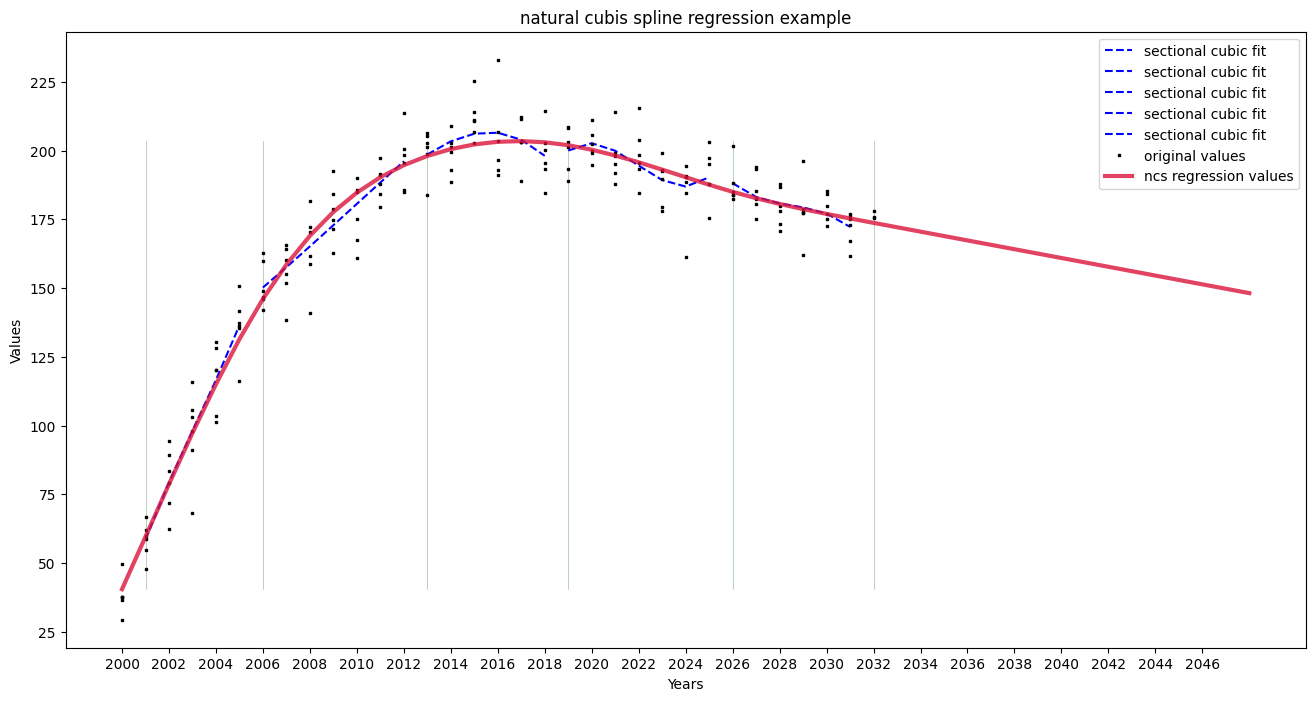

In [20]:
perc_ncs = 65
'''
limit_ncs = int(len(oj_years)*perc_ncs/100) #limit_ncs to the first perc_ncs % of the data
limit_pred_ncs = int(len(oj_years)* (perc_ncs/100)*1.5) #limit_ncs the prediction to 1.5* perc_ncs % of the data
reg_years_ncs = oj_years[0:limit_ncs]
reg_values_ncs = oj_values[0:limit_ncs]
'''
limit_ncs = int(len(multi_noisy_years)*perc_ncs/100) #limit_ncs to the first perc_ncs % of the data
limit_pred_ncs = int(len(multi_noisy_years)* (perc_ncs/100)*1.5) #limit_ncs the prediction to 1.5* perc_ncs % of the data
reg_years_ncs = multi_noisy_years[0:limit_ncs]
reg_values_ncs = multi_noisy_values[0:limit_ncs]
reg_predictor_years_ncs = multi_noisy_years[0:limit_pred_ncs]

inputs_ncs = reg_years_ncs
outputs_ncs = reg_values_ncs
pred_inputs = reg_predictor_years_ncs

# we can either choose the knots manually, or supply a number of knots
# - see second graphic on top.
# knots at the 2nd and 2nd to last points, and at 20%, 40%, 60% and 80%
knots = [inputs[1], inputs_ncs[int(0.2*len(inputs_ncs))],inputs_ncs[int(0.4*len(inputs_ncs))],
        inputs_ncs[int(0.6*len(inputs_ncs))], inputs_ncs[int(0.8*len(inputs_ncs))], inputs_ncs[-2]]


# just for showing the different cubic fits
sections = []
for i, knot in enumerate(knots[1:]):
    index_first = np.where(inputs_ncs == knots[i])[0][0]
    index_second = np.where(inputs_ncs == knot)[0][0]
    section_years = inputs_ncs[index_first:index_second]
    section_values = outputs_ncs[index_first:index_second]
    sections.append([section_years, section_values])

# setting up the actual model (training)
ncs_model = ncs.get_natural_cubic_spline_model(inputs_ncs, outputs_ncs, minval=min(inputs_ncs), 
                                               maxval=max(inputs_ncs), knots = knots)
# predicting of the single curve by the model
pred_outputs = ncs_model.predict(pred_inputs)
print(f'The ncs_model')

fig=plt.figure(figsize = (16,8))
#plot the knots:
for knot in knots:
    plt.plot([knot, knot], [min(pred_outputs), max(pred_outputs)], lw = 0.5, color = 'darkgreen', 
             alpha = 0.4)

for section in sections:
    [x,y] = section
    polynomial = np.poly1d(np.polyfit(x, y, 3))
    pol_outputs = polynomial(x)
    plt.plot(x, pol_outputs, '--', color = 'blue', lw = 1.5, label = 'sectional cubic fit')

plt.plot(reg_years_ncs, reg_values_ncs, 's', color = 'black', markersize = 2, 
         label = f'original values')
plt.plot(pred_inputs, pred_outputs, color = 'crimson', lw = 3, alpha = 0.8,
         label = 'ncs regression values')
plt.legend(loc = 'best')
ticks = np.rint(oj_years[:int(len(oj_years)*perc_ncs/100*1.5):int(len(reg_predictor_years)/10)])
plt.xticks(ticks = ticks)
plt.xlabel('Years')
plt.ylabel('Values')
plt.title('natural cubis spline regression example')
plt.show()
#plt.savefig(f'my_res{datetime.now().hour}.png', dpi = 1000)

# Tasks
You will now have to perform some regression analysis with a new (real) dataset - the focus is on you understanding how the methods work and to start visualizing the results in jupyter notebooks.

### The data set:

We will calculate the chinese vehicle stock based on the data used in the previous warm-ups. Assuming that the vehicles are providing the service of transport and that it is the provision of this service that drives the system, we calculate the stock based on the population and vehicles per capita for a stock driven model. 

Your task is to calibrate your model based on the available data and validate your assumptions using a stock-driven model. 

In [21]:
#pip install xlrd

In [22]:
# importing the calibration data
data = pd.read_excel('warm-up15-data.xls', sheet_name='calibration', skiprows=1)
validation = pd.read_excel( 'warm-up15-data.xls', sheet_name='validation')

In [23]:
# defining the parameters as np.arrays
year = np.array(data.Time)
population = np.array(data.Population)
vpc = np.array(data['cars per 1000 people']) # vpc stands for vehicles per capita

## Your task: perform all types of regression and analyze

You will now test all three types of regression on both data sets population and vpc. Do one regression at the time and plot its results together with the raw data, then combine all the different types in one plot and compare.
<br>
After this you will calculate the stock_t and inflows and outflows based on this, and compare to the validation data.

**Note**: all the empty plots below must be filled for you to get a pass on the warm-up!
<br>
Good luck and have fun!


## First data set:
What it is

#### Visualize the raw data
Your first job is always to get an overview of what you are dealing with, so please plot the raw data here.

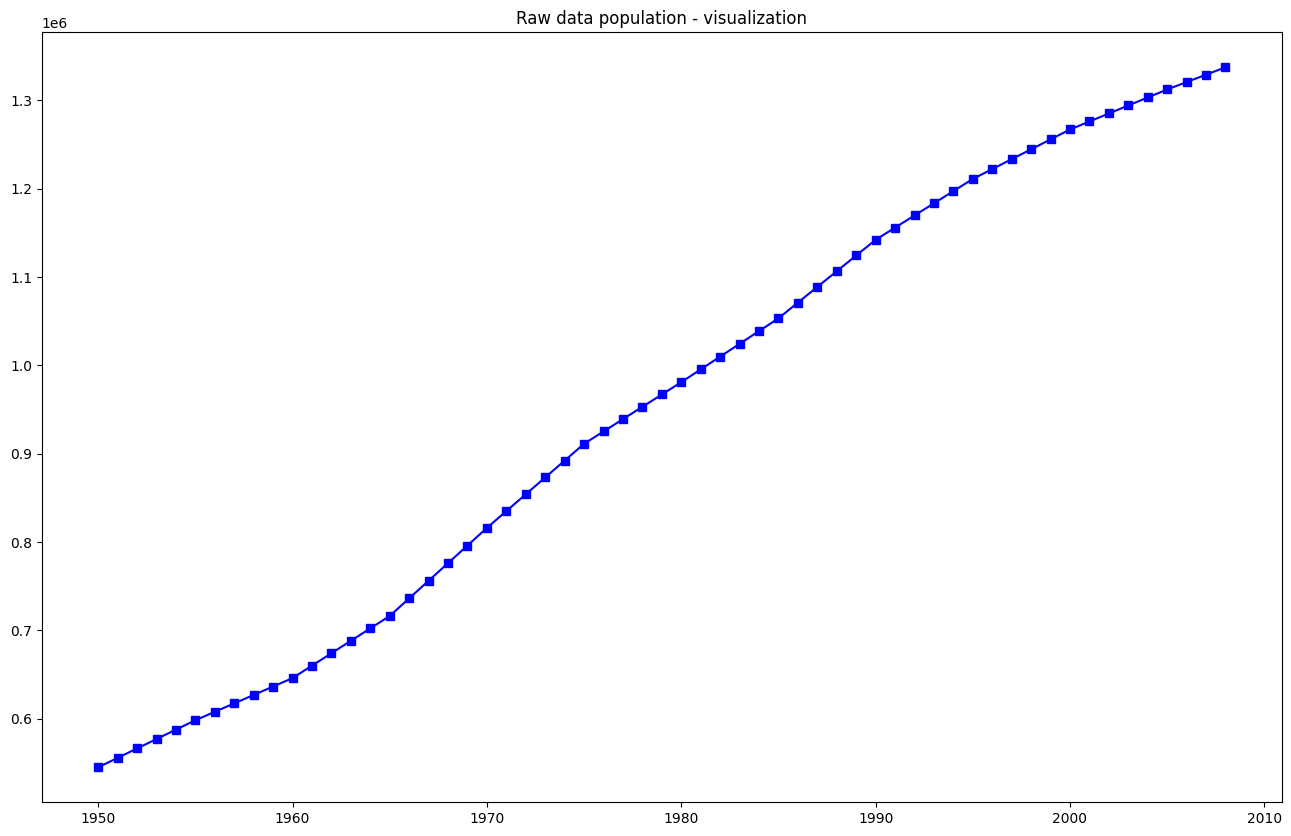

In [24]:
plt.figure(figsize=(16,10))
plt.plot(year, population, 's-', color = 'blue', label = 'population')
plt.title('Raw data population - visualization')
plt.show()


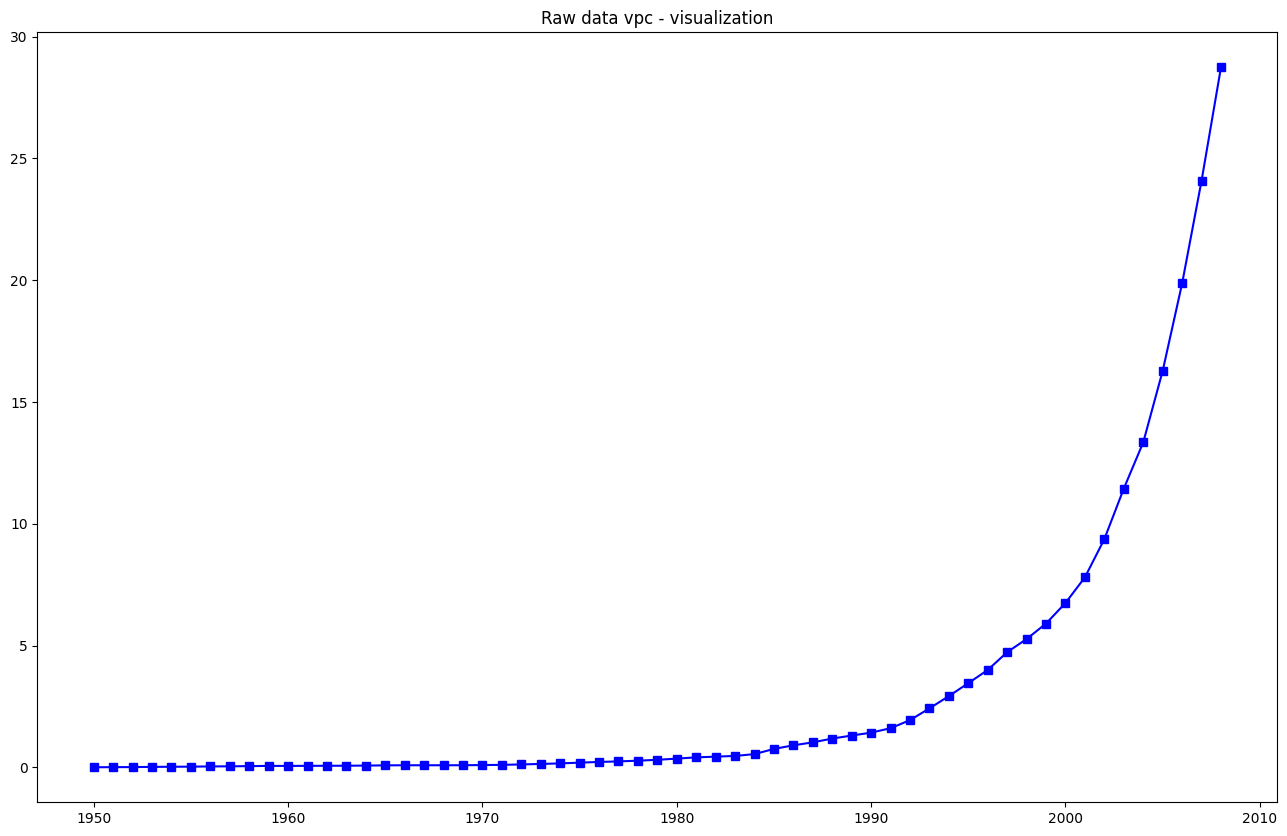

In [25]:
plt.figure(figsize=(16,10))
plt.plot(year, vpc, 's-', color = 'blue', label = 'vpc')
plt.title('Raw data vpc - visualization')
plt.show()

### Polynomial regression
Test some polynomial regressions for both data sets here.

 the polynomial our fit created is: 
         3        2
-0.2911 x + 1771 x - 3.593e+06 x + 2.43e+09.


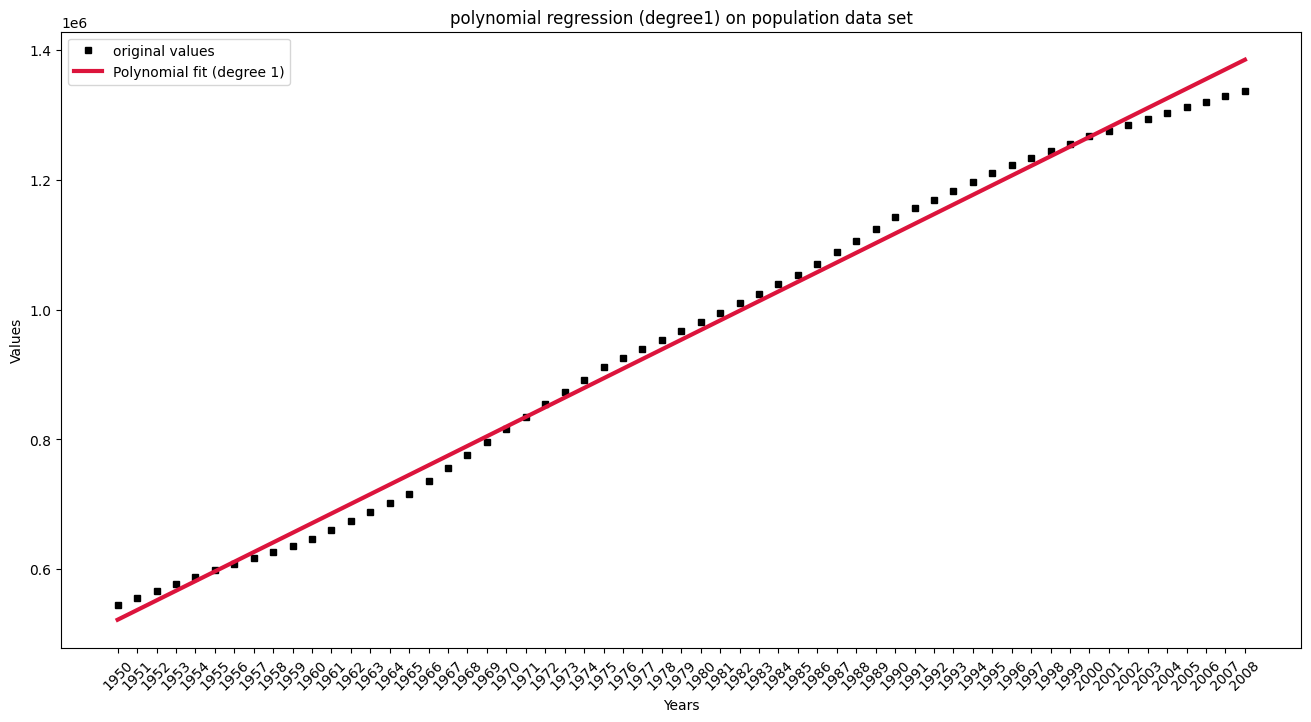

In [30]:
## Polynomial regression on population data set ##

inputs = year
outputs = population

#perform regression:
#set degreee:
degree = 1
#find polynomial
polynomial_pop = np.poly1d(np.polyfit(inputs, outputs, degree))
print(f' the polynomial our fit created is: \n{polynomial}.')

x_curve = np.linspace(min(inputs), max(inputs), 100)
y_curve = polynomial_pop(x_curve)

fig=plt.figure(figsize = (16,8))
plt.plot(inputs, outputs, 's', color = 'black', markersize = 5, label = f'original values')
plt.plot(x_curve, y_curve, color = 'crimson', lw = 3, label = f'Polynomial fit (degree {degree})')
plt.legend(loc = 'best')
plt.xticks(year, rotation = 45)
plt.xlabel('Years')
plt.ylabel('Values')
plt.title(f'polynomial regression (degree{degree}) on population data set')
plt.show()



 the polynomial our fit created is: 
         3        2
-0.2911 x + 1771 x - 3.593e+06 x + 2.43e+09.


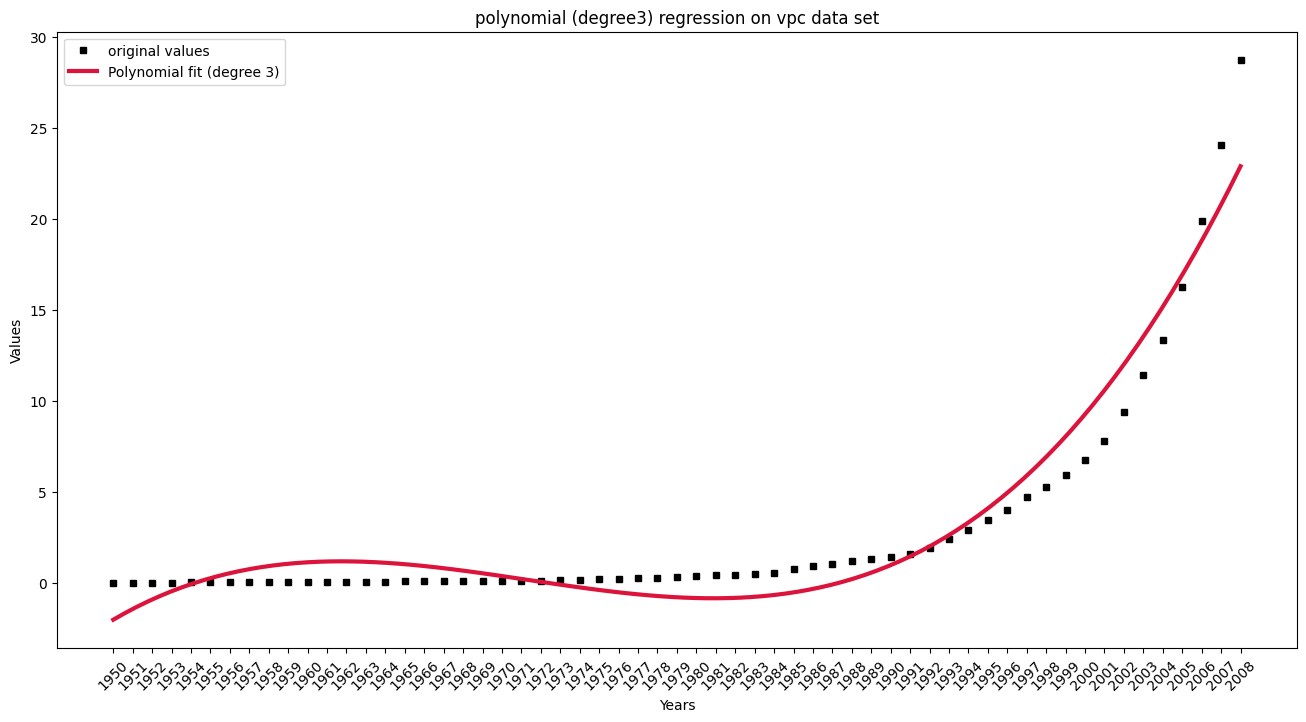

In [31]:
## Polynomial regression on vpc data set ## 

inputs = year
outputs = vpc

#perform regression:
#set degreee:
degree = 3
#find polynomial
polynomial_vpc = np.poly1d(np.polyfit(inputs, outputs, degree))
print(f' the polynomial our fit created is: \n{polynomial}.')

x_curve = np.linspace(min(inputs), max(inputs), 100)
y_curve = polynomial_vpc(x_curve)

fig=plt.figure(figsize = (16,8))
plt.plot(inputs, outputs, 's', color = 'black', markersize = 5, label = f'original values')
plt.plot(x_curve, y_curve, color = 'crimson', lw = 3, label = f'Polynomial fit (degree {degree})')
plt.legend(loc = 'best')
plt.xticks(year, rotation = 45)
plt.xlabel('Years')
plt.ylabel('Values')

plt.title(f'polynomial (degree{degree}) regression on vpc data set')
plt.show()

#### Logistic regression 
Try logistic regression (maybe with different boundaries) for both data sets here.


Optimal parameters: ti=1976.12, tau=15.85, C0=363489.97, C1=1465418.49


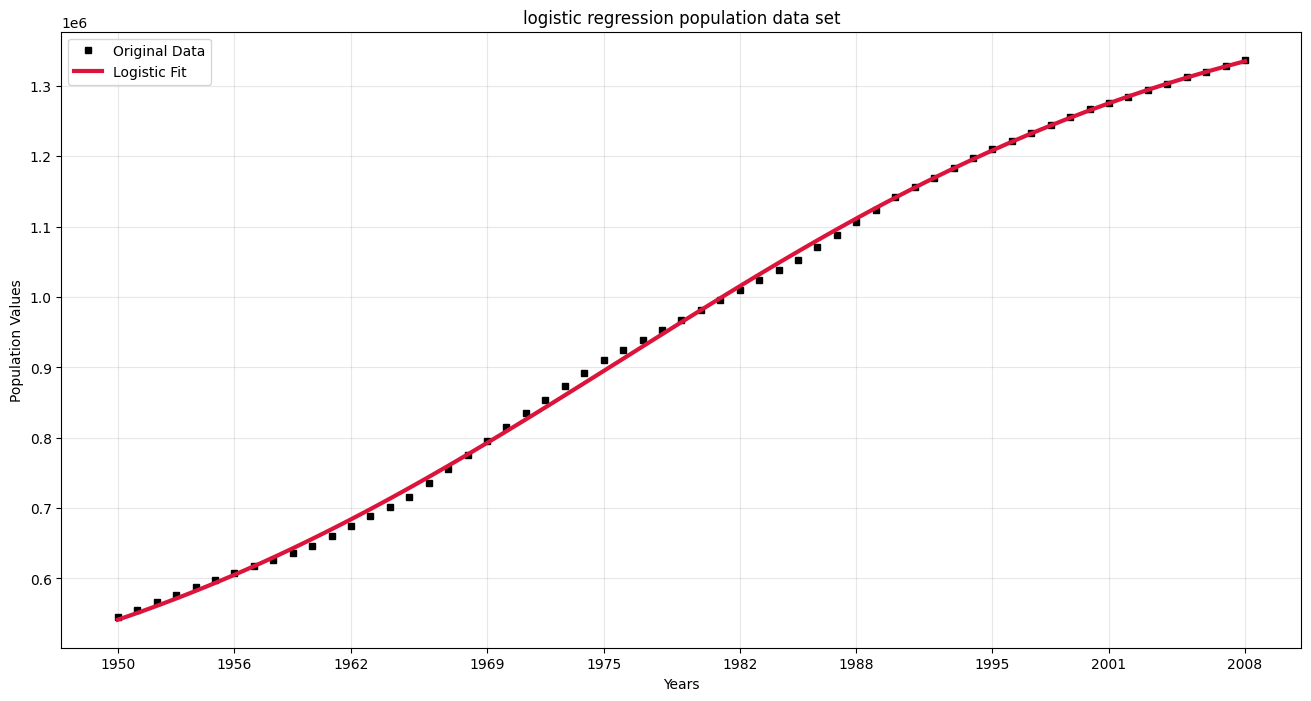

In [32]:
## Logistic regression on pop data set ##

inputs = year 
outputs = population

# Initial Guesses 
est_ti = np.median(inputs)           # Guess the inflection point is in the middle of the timeline
est_tau = 10                         # Growth rate constant
est_C0 = min(outputs)                # Initial population offset
est_C1 = max(outputs) * 1.5          # Assume the saturation limit (carrying capacity) is higher than current max

initial_guess = [est_ti, est_tau, est_C0, est_C1]

# Define bounds
lower_bounds = [min(inputs) - 50, 0.1, 0, 0]
upper_bounds = [max(inputs) + 50, 500, max(outputs) * 5, 10**12]

# Perform the Logistic Regression
try:
    popt_pop, pcov_pop = curve_fit(
        logistic, 
        inputs, 
        outputs, 
        p0=initial_guess, 
        bounds=(lower_bounds, upper_bounds)
    )
    print(f'Optimal parameters: ti={popt_pop[0]:.2f}, tau={popt_pop[1]:.2f}, C0={popt_pop[2]:.2f}, C1={popt_pop[3]:.2f}')
except Exception as e:
    print(f"Fitting failed: {e}")

# Plotting
x_curve = np.linspace(min(inputs), max(inputs), 100)
y_curve = logistic(x_curve, *popt_pop)

# Visualization
fig = plt.figure(figsize=(16, 8))

# Plot the raw data points
plt.plot(inputs, outputs, 's', color='black', markersize=5, label='Original Data')

# Plot the resulting regression curve
plt.plot(x_curve, y_curve, color='crimson', lw=3, label='Logistic Fit')

plt.xticks(np.linspace(min(inputs), max(inputs), 10).astype(int))
plt.xlabel('Years')
plt.ylabel('Population Values')
plt.title(f'logistic regression population data set')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

Optimal parameters: ti=2058.00, tau=5.63, C0=0.14, C1=204393.81


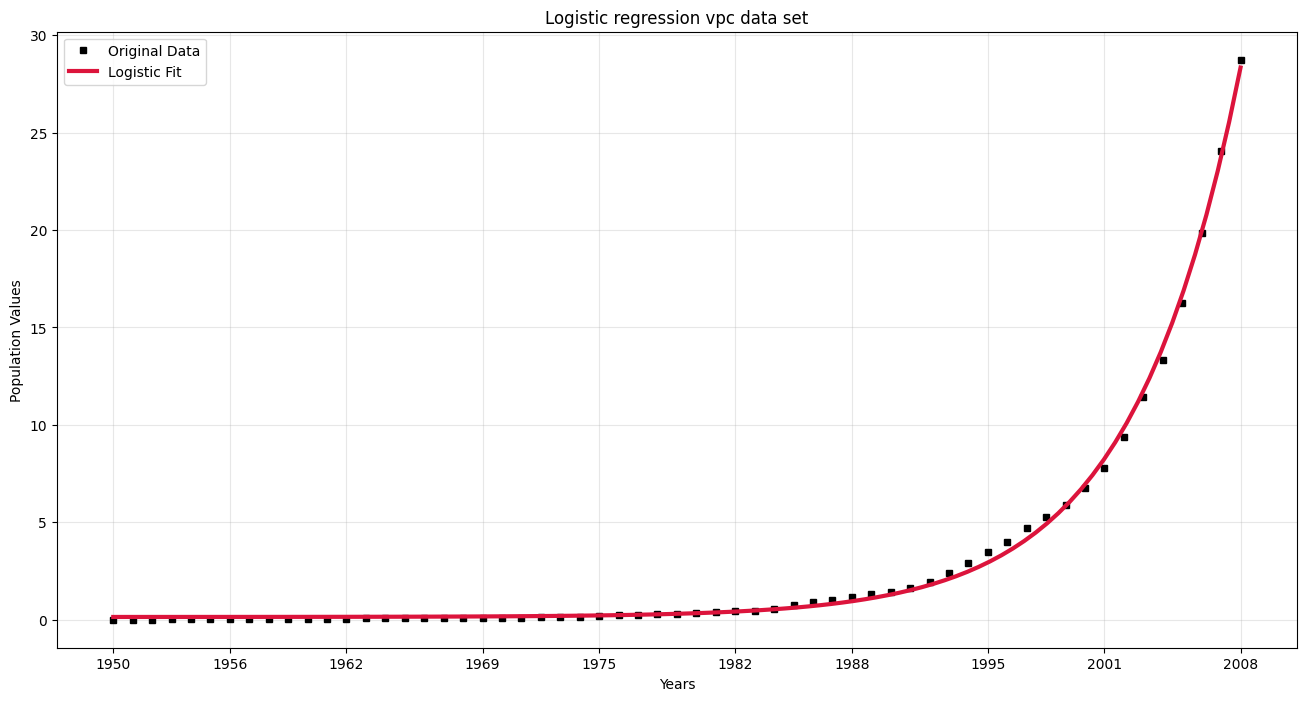

In [33]:
## Logistic regression on vpc data set ##

inputs = year
outputs = vpc

# Initial Guesses 
est_ti = np.median(inputs)           # Guess the inflection point is in the middle of the timeline
est_tau = 10                         # Growth rate constant
est_C0 = min(outputs)                # Initial population offset
est_C1 = max(outputs) * 1.5           # Assume the saturation limit (carrying capacity) is higher than current max

initial_guess = [est_ti, est_tau, est_C0, est_C1]

# Define bounds
lower_bounds = [min(inputs) - 50, 0.1, 0, 0]
upper_bounds = [max(inputs) + 50, 500, max(outputs) * 5, 10**12]

# Perform the Logistic Regression
try:
    popt_vpc, pcov = curve_fit(
        logistic, 
        inputs, 
        outputs, 
        p0=initial_guess, 
        bounds=(lower_bounds, upper_bounds)
    )
    print(f'Optimal parameters: ti={popt_vpc[0]:.2f}, tau={popt_vpc[1]:.2f}, C0={popt_vpc[2]:.2f}, C1={popt_vpc[3]:.2f}')
except Exception as e:
    print(f"Fitting failed: {e}")

# Plotting
x_curve = np.linspace(min(inputs), max(inputs), 100)
y_curve = logistic(x_curve, *popt_vpc)

# Visualization
fig = plt.figure(figsize=(16, 8))

# Plot the raw data points
plt.plot(inputs, outputs, 's', color='black', markersize=5, label='Original Data')

# Plot the resulting regression curve
plt.plot(x_curve, y_curve, color='crimson', lw=3, label='Logistic Fit')

plt.xticks(np.linspace(min(inputs), max(inputs), 10).astype(int))
plt.xlabel('Years')
plt.ylabel('Population Values')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.title('Logistic regression vpc data set')
plt.show()

#### Natural cubic spline regression 
Try some natural cubic spline regression for both data sets here.

**Note** that the results of a ncs regression can vary significantly on the number of knots (or knots given as a list of input variable values), so try some different here. 
<br> Use n_knots = some_integer and knots = list[integer1, integer2] (e.g, knots = [2001, 2010, 2020, 2029] or n_knots = 8).

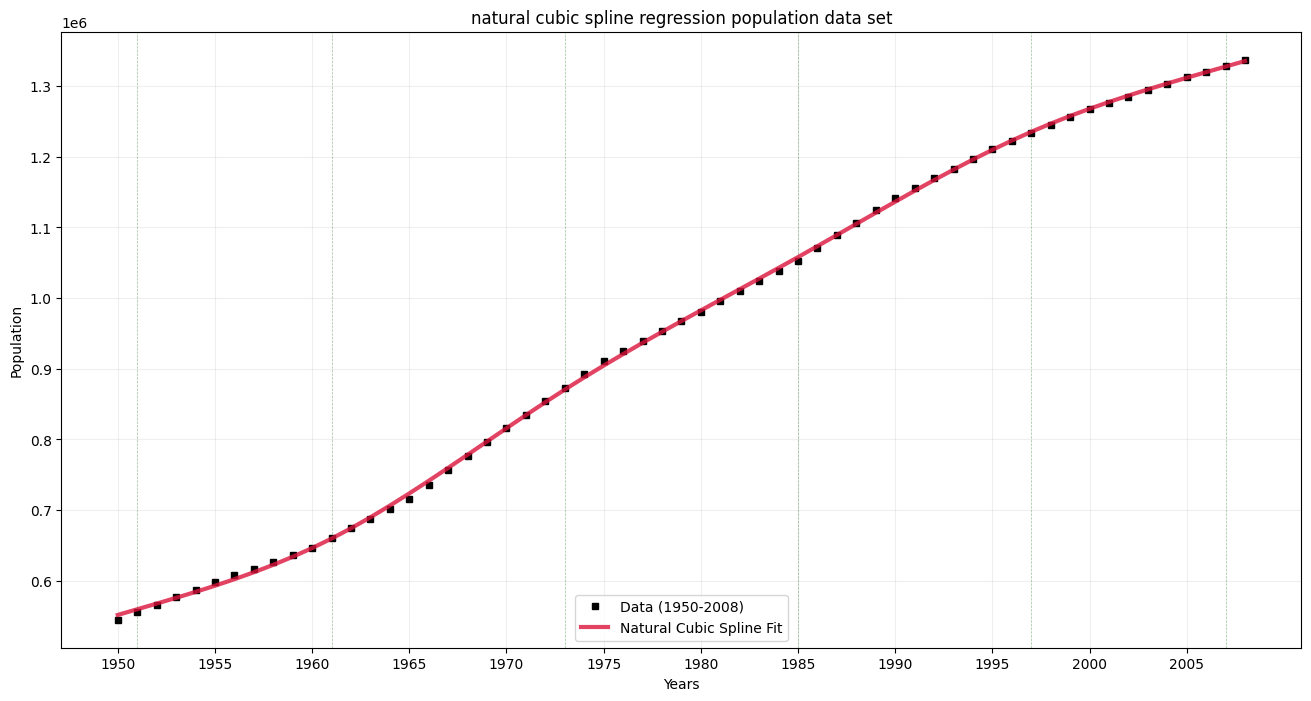

In [34]:
## Natural Cubic Spline regression on population data set ##

inputs_ncs = year
outputs_ncs = population
pred_inputs = inputs_ncs 

# Define the knots 
knots = [inputs_ncs[1], 
         inputs_ncs[int(0.2*len(inputs_ncs))],
         inputs_ncs[int(0.4*len(inputs_ncs))],
         inputs_ncs[int(0.6*len(inputs_ncs))], 
         inputs_ncs[int(0.8*len(inputs_ncs))], 
         inputs_ncs[-2]]

# Setting up the NCS model
ncs_model_pop = ncs.get_natural_cubic_spline_model(
    inputs_ncs, outputs_ncs, 
    minval=min(inputs_ncs), 
    maxval=max(inputs_ncs), 
    knots=knots
)

# Generate the fit values
pred_outputs = ncs_model_pop.predict(pred_inputs)

# Visualization
fig = plt.figure(figsize=(16, 8))

# Plot vertical lines for knots 
for knot in knots:
    plt.axvline(x=knot, color='darkgreen', lw=0.5, alpha=0.4, linestyle='--')

# Plot the real data points
plt.plot(inputs_ncs, outputs_ncs, 's', color='black', markersize=4, label='Data (1950-2008)')

# Plot the NCS regression curve
plt.plot(pred_inputs, pred_outputs, color='crimson', lw=3, alpha=0.8, label='Natural Cubic Spline Fit')

# Formatting the X-axis to show specific years
plt.xticks(np.arange(1950, 2010, 5)) 
plt.xlabel('Years')
plt.ylabel('Population')
plt.title('natural cubic spline regression population data set')
plt.legend(loc='best')
plt.grid(True, alpha=0.2)
plt.show()

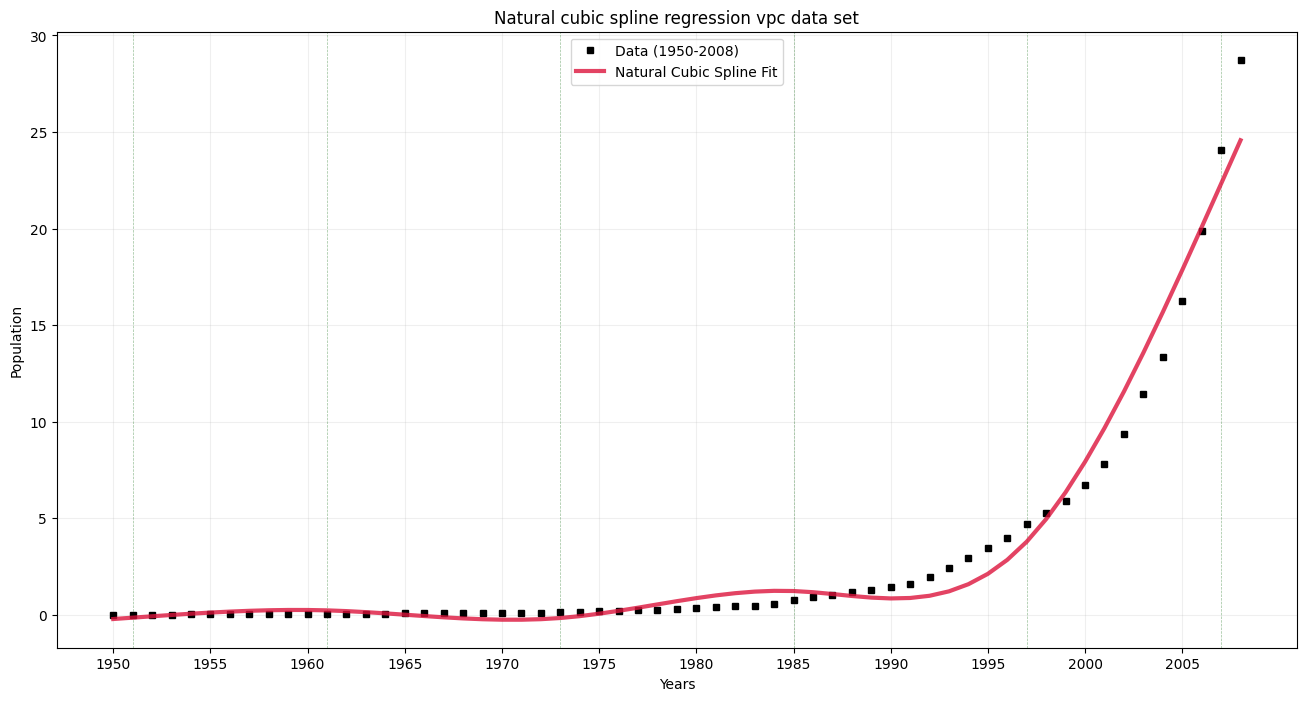

In [35]:
## Natural Cubic Spline regression on vpc data set ##

inputs_ncs = year
outputs_ncs = vpc
pred_inputs = inputs_ncs 

# Define the knots 
knots = [inputs_ncs[1], 
         inputs_ncs[int(0.2*len(inputs_ncs))],
         inputs_ncs[int(0.4*len(inputs_ncs))],
         inputs_ncs[int(0.6*len(inputs_ncs))], 
         inputs_ncs[int(0.8*len(inputs_ncs))], 
         inputs_ncs[-2]]

# Setting up the NCS model
ncs_model_vpc = ncs.get_natural_cubic_spline_model(
    inputs_ncs, outputs_ncs, 
    minval=min(inputs_ncs), 
    maxval=max(inputs_ncs), 
    knots=knots
)

# Generate the fit values
pred_outputs = ncs_model_vpc.predict(pred_inputs)

# Visualization
fig = plt.figure(figsize=(16, 8))

# Plot vertical lines for knots 
for knot in knots:
    plt.axvline(x=knot, color='darkgreen', lw=0.5, alpha=0.4, linestyle='--')

# Plot the real data points
plt.plot(inputs_ncs, outputs_ncs, 's', color='black', markersize=4, label='Data (1950-2008)')

# Plot the NCS regression curve
plt.plot(pred_inputs, pred_outputs, color='crimson', lw=3, alpha=0.8, label='Natural Cubic Spline Fit')

# Formatting the X-axis to show specific years
plt.xticks(np.arange(1950, 2010, 5)) 
plt.xlabel('Years')
plt.ylabel('Population')
plt.legend(loc='best')
plt.grid(True, alpha=0.2)
plt.title('Natural cubic spline regression vpc data set')
plt.show()

#### comparison of regressions
Compare your results of the different regression techniques here, and write some interpretation on the most useful in the markdown below!

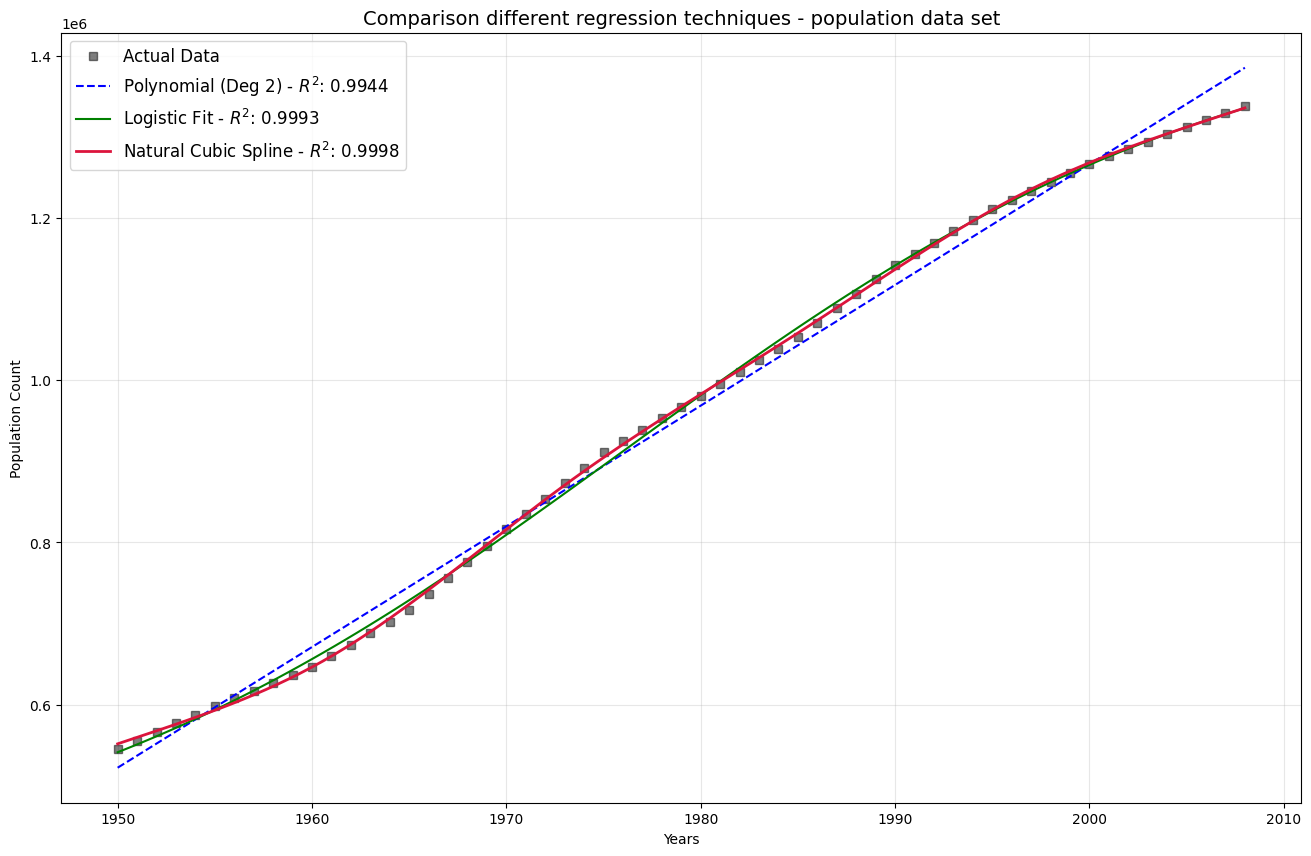

In [36]:
# Ensure inputs and outputs are defined
inputs = year
outputs = population 
x_curve = np.linspace(min(inputs), max(inputs), 100)

# --- 1. CALCULATE R2 SCORES ---

# Polynomial R2
poly_preds_r2 = polynomial_pop(inputs)
r2_poly = r2_score(outputs, poly_preds_r2)

# Logistic R2
log_preds_r2 = logistic(inputs, *popt_pop)
r2_log = r2_score(outputs, log_preds_r2)

# NCS R2
ncs_preds_r2 = ncs_model_pop.predict(inputs)
r2_ncs = r2_score(outputs, ncs_preds_r2)

# --- 2. GENERATE SMOOTH CURVES FOR PLOTTING ---
poly_plot = polynomial_pop(x_curve)
log_plot = logistic(x_curve, *popt_pop)
ncs_plot = ncs_model_pop.predict(x_curve)

# --- 3. PLOTTING ---
plt.figure(figsize=(16, 10))
plt.plot(year, population, 's', color='black', alpha=0.5, label='Actual Data')

# Courbe Polynomiale with R2
plt.plot(x_curve, poly_plot, '--', color='blue', 
         label=f'Polynomial (Deg 2) - $R^2$: {r2_poly:.4f}')

# Courbe Logistique with R2

plt.plot(x_curve, log_plot, '-', color='green', 
         label=f'Logistic Fit - $R^2$: {r2_log:.4f}')

# Courbe NCS with R2
plt.plot(x_curve, ncs_plot, '-', color='crimson', lw=2, 
         label=f'Natural Cubic Spline - $R^2$: {r2_ncs:.4f}')

plt.title('Comparison different regression techniques - population data set', fontsize=14)
plt.xlabel('Years')
plt.ylabel('Population Count')
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

By plotting the $R^2$ scores, we can clearly evaluate the performance of each model. All scores are above 0.99, indicating a strong correlation between the data and the models, even for the linear regression. The $R^2$ values confirm our visual observations: the linear regression provides the least precise fit of the three.The Natural Cubic Spline ($R^2 = 0.9998$) fits the data almost perfectly. This is expected, as it is the most complex model; however, given its higher computational cost, it might be unnecessary for this specific use case. The logistic fit ($R^2 = 0.9993$) represents an excellent compromise between computational efficiency and accuracy

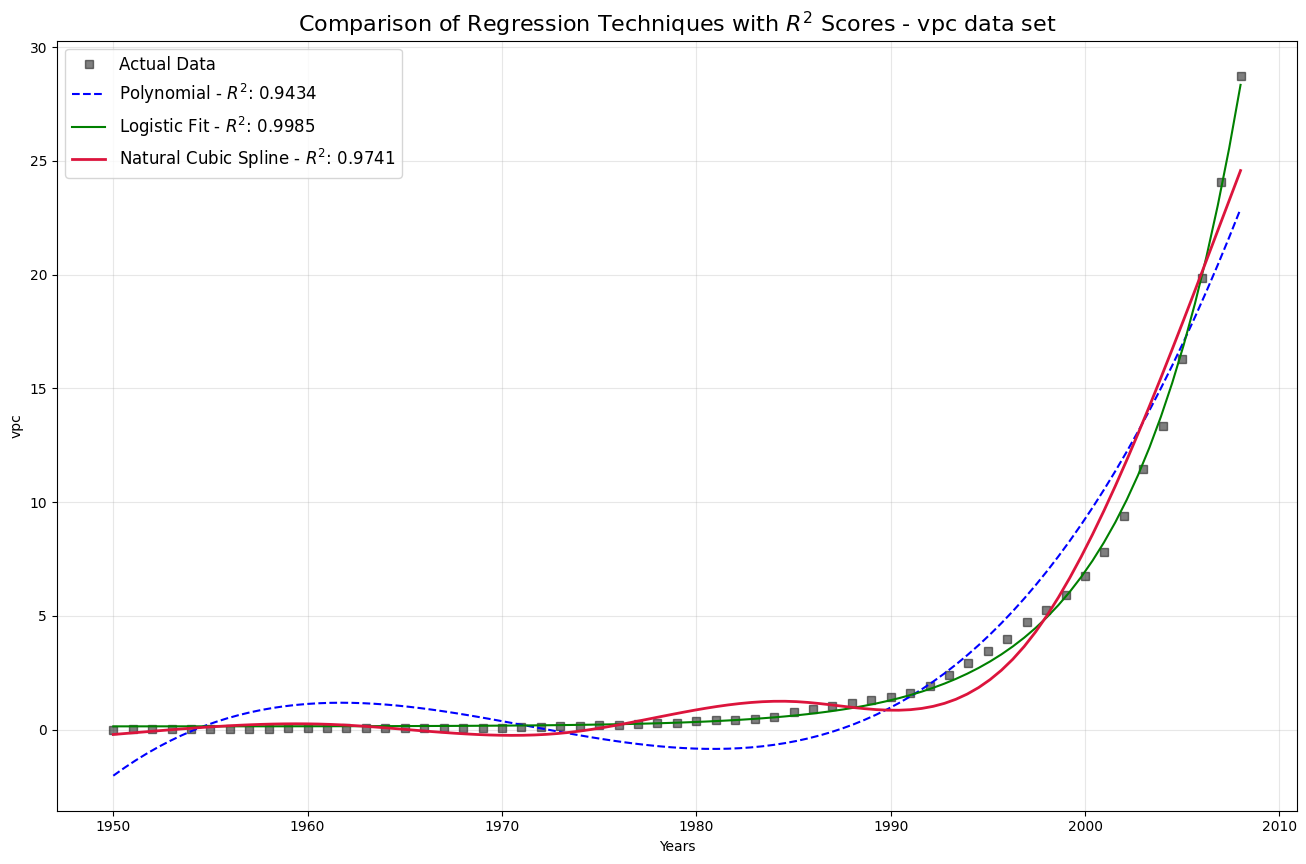

In [37]:
# Ensure variables are set
inputs = year
outputs = vpc
x_curve = np.linspace(min(inputs), max(inputs), 100)

# --- 1. R2 CALCULATIONS ---
# Polynomial R2
poly_preds = polynomial_vpc(inputs)
r2_poly = r2_score(outputs, poly_preds)

# Logistic R2
log_preds = logistic(inputs, *popt_vpc)
r2_log = r2_score(outputs, log_preds)

# NCS R2
ncs_preds = ncs_model_vpc.predict(inputs)
r2_ncs = r2_score(outputs, ncs_preds)

# --- 2. SMOOTH CURVE GENERATION FOR PLOTTING ---
poly_plot = polynomial_vpc(x_curve)
log_plot = logistic(x_curve, *popt_vpc)
ncs_plot = ncs_model_vpc.predict(x_curve)

# --- 3. PLOTTING ---
plt.figure(figsize=(16, 10))

# Plot Actual Data
plt.plot(year, vpc, 's', color='black', alpha=0.5, label='Actual Data')

# Plot Polynomial with R2
plt.plot(x_curve, poly_plot, '--', color='blue', 
         label=f'Polynomial - $R^2$: {r2_poly:.4f}')

# Plot Logistic with R2
plt.plot(x_curve, log_plot, '-', color='green', 
         label=f'Logistic Fit - $R^2$: {r2_log:.4f}')

# Plot NCS with R2
plt.plot(x_curve, ncs_plot, '-', color='crimson', lw=2, 
         label=f'Natural Cubic Spline - $R^2$: {r2_ncs:.4f}')

plt.title('Comparison of Regression Techniques with $R^2$ Scores - vpc data set', fontsize=16)
plt.xlabel('Years')
plt.ylabel('vpc')
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

The raw data for this variable presents a more complex curve than the population data. A polynomial fit is insufficient here, as evidenced by an $R^2$ of only 0.94. The logistic model performs the best because the original data follows a classic logistic trajectory: an initial period of slow growth followed by a sharp, rapid increase. The $R^2$ is 0.9985. In contrast, the Natural Cubic Spline (NCS) is less effective in this case with a $R^2$ of 0.9741. Large segments of the curve are nearly constant, which makes it difficult to link multiple cubic polynomials together into a cohesive and accurate fit. This suggests that the underlying trend is better captured by a continuous growth model than by piecewise approximations.


#### Interpretation

Please explain shortly which regression works best for which data set, and why you think that is.



Done after each graph


### Stock driven model.
Use the values from the best regression for a stock driven model of the chinese vehicle fleet from 1950 until 2020. Calculate inflows and outflows and compare with the validation data

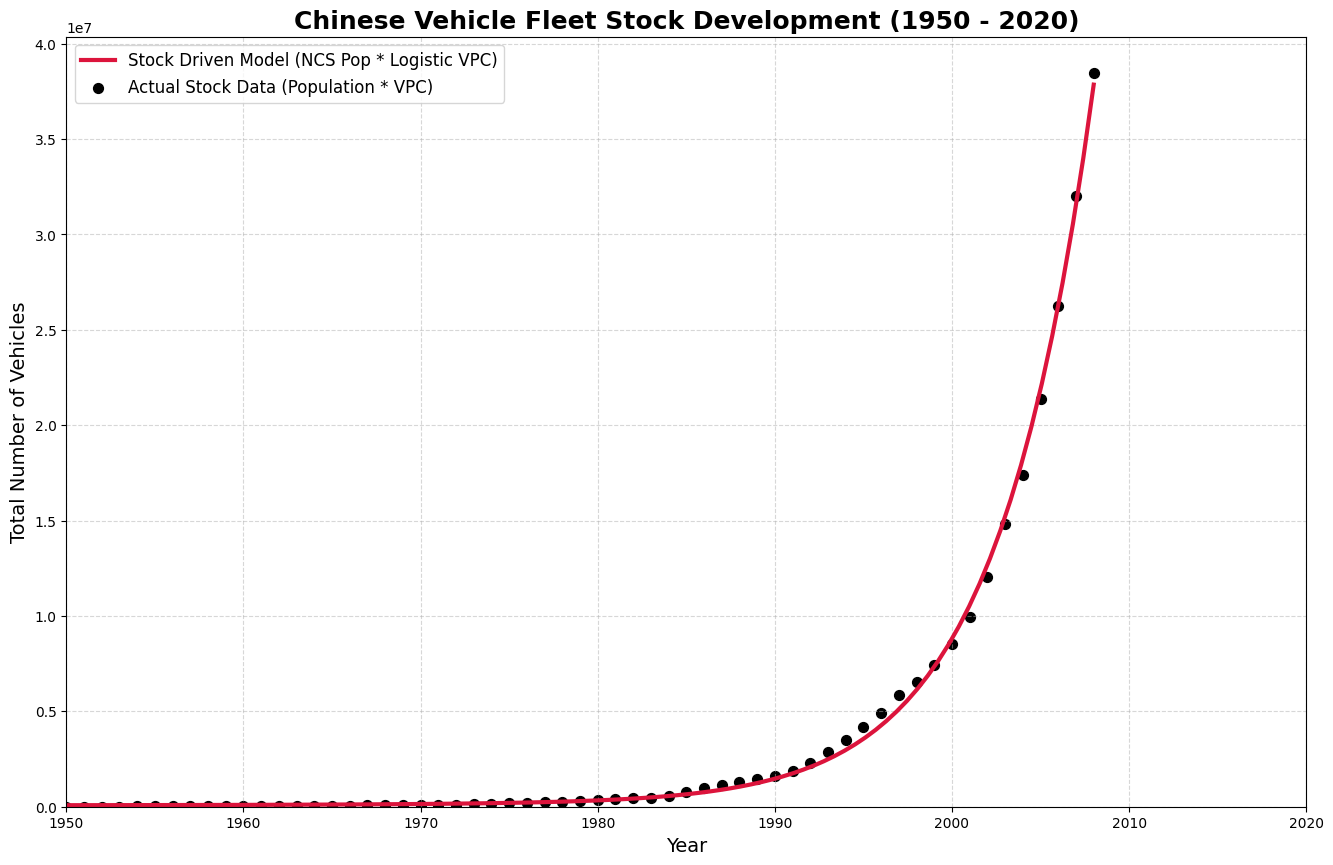

In [55]:
# Setup
inputs = year
x = np.linspace(min(inputs), 2008, 100)

# Computing the stock development 
pop_model = ncs_model_pop.predict(x)
vpc_model = logistic(x, *popt_vpc)
stock_t = pop_model * vpc_model

# Enhanced Plotting
plt.figure(figsize=(16, 10))

# Plot the model as a smooth line
plt.plot(x, stock_t, color='crimson', lw=3, label='Stock Driven Model (NCS Pop * Logistic VPC)')
plt.scatter(year, population * vpc, color='black', alpha=1, label='Actual Stock Data (Population * VPC)', s=50)
# Labels
plt.title('Chinese Vehicle Fleet Stock Development (1950 - 2020)', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Number of Vehicles', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)

# Optional: Set axis limits to start from 1950 exactly

plt.xlim(1950, 2020)
plt.ylim(bottom=0)

plt.show()

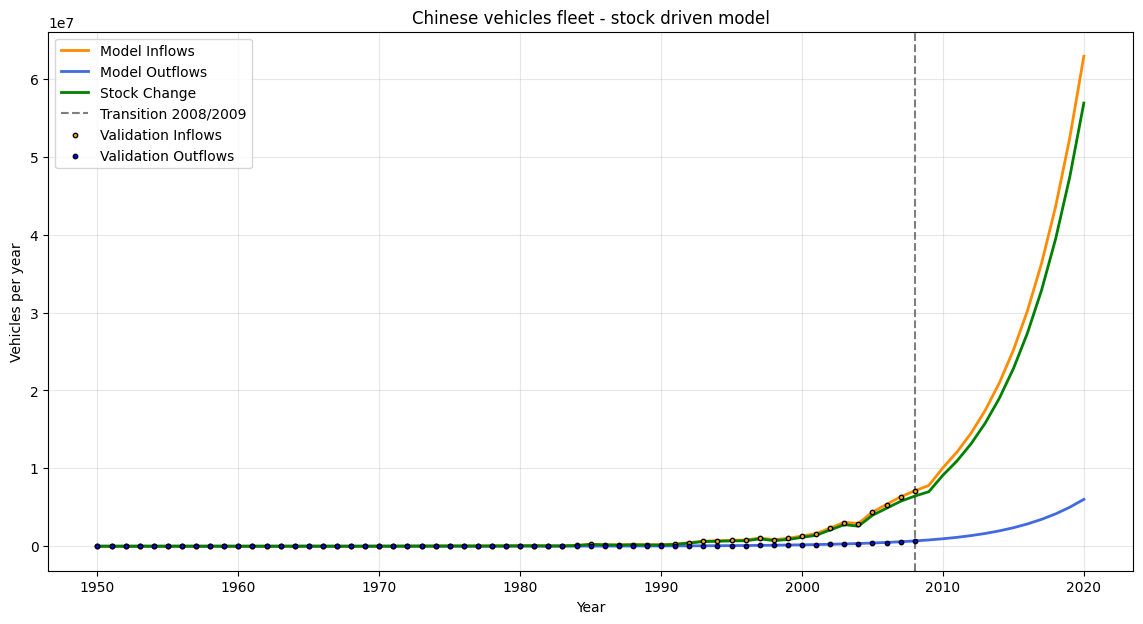

In [ ]:
from scipy.stats import norm

# Define Time Range 
start_year = 1950
end_year_hist = 2008
end_year_pred = 2020
years_full = np.arange(start_year, end_year_pred + 1)
n_years = len(years_full)

# Construct the Composite Stock Vector 
hist_stock = population * vpc 

x_pred = np.arange(end_year_hist + 1, end_year_pred + 1)
pop_pred = ncs_model_pop.predict(x_pred)
vpc_pred = logistic(x_pred, *popt_vpc)
pred_stock = pop_pred * vpc_pred

full_stock = np.concatenate([hist_stock, pred_stock])

# Pre-calculate delta stock for all years (Stock Change)
delta_stock_vec = np.diff(full_stock, prepend=0)

# Lifetime Distribution (PDF)
mean_l = 15
std_dev_l = 5
max_age = 100
pdf_lifetime = norm.pdf(np.arange(max_age), loc=mean_l, scale=std_dev_l)
pdf_lifetime /= pdf_lifetime.sum()

# Iterative calculation
inflows_calc = np.zeros(n_years)
outflows_calc = np.zeros(n_years)

for t in range(n_years):
    # Calculate Outflow based on past calculated inflows
    if t > 0:
        past_inflows = inflows_calc[:t]
        exit_probs = pdf_lifetime[1:t+1][::-1]
        outflows_calc[t] = np.sum(past_inflows * exit_probs)
    
    # Use the pre-calculated delta from the vector
    delta_stock = delta_stock_vec[t]
    
    # Resulting Inflow required to satisfy the stock change and outflows
    inflows_calc[t] = delta_stock + outflows_calc[t]

# Validation data
outflow_validation = np.array(validation.Outflow)
inflow_validation = np.array(validation.Inflow)

# Final Visualization
plt.figure(figsize=(14, 7))
plt.plot(years_full, inflows_calc, label='Model Inflows', color='darkorange', lw=2)
plt.plot(years_full, outflows_calc, label='Model Outflows', color='royalblue', lw=2)
plt.plot(years_full, delta_stock_vec, label='Stock Change', color='green', lw=2) # Now works
plt.axvline(x=2008, color='black', linestyle='--', alpha=0.5, label='Transition 2008/2009')

plt.scatter(validation.Time, inflow_validation, color='orange', edgecolor='black', s=10, label='Validation Inflows', zorder=5)
plt.scatter(validation.Time, outflow_validation, color='blue', edgecolor='black', s=10, label='Validation Outflows', zorder=5)

plt.title('Chinese vehicles fleet - stock driven model')
plt.xlabel('Year')
plt.ylabel('Vehicles per year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Interpretation
What to you think about your validation? Did it move you to change your regression method?

The stock from 1950 to 2008 had been calculated correctly, both inflow and outflow matched the validation data. The prediction seems also alright,the outflow in 2020 is almsot the same as the inflows 15 years ago (the mean of the PDF). the outflow minus the inflows seems to be equal to the stock change.

### Well done!